In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import gc
import os
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import scipy as sp
import cv2
from tqdm.notebook import tqdm
from skimage.metrics import structural_similarity as ssim
import deepwave

import deepinvhessian.fwi as fwi
from deepinvhessian.utilities import *
from deepinvhessian.filters import *
from deepinvhessian.train import *
from deepinvhessian.masks import *
from unet import *

In [2]:
set_seed(14)
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Prepare data

In [3]:
# Define the model and acquisition parameters
par = {'nx':601,   'dx':0.015, 'ox':0,
       'nz':221,   'dz':0.015, 'oz':0,
       'num_shots':30,    'ds':0.3,   'os':0,  'sz':0,
       'num_receivers_per_shot':300,   'dr':0.03,  'orec':0, 'rz':0,
       'nt':5000,  'dt':0.001,  'ot':0,
       'freq': 5, 'num_sources_per_shot':1, 'num_dims':2,
       'num_batches':30,
        'FWI_itr': 100
      }

velocity_file = '../data/Marm.bin' 

In [4]:
# Load the true model
model_true = (np.fromfile(velocity_file, np.float32)
              .reshape(par['nz'], par['nx']))

# function to get water layer mask
def mask(model,value):
    """
    Return a mask for the model (m) using the (value)
    """
    mask = model > value
    mask = mask.astype(int)
    mask[:21] = 0
    return mask

mask = mask(model_true, 1.5)

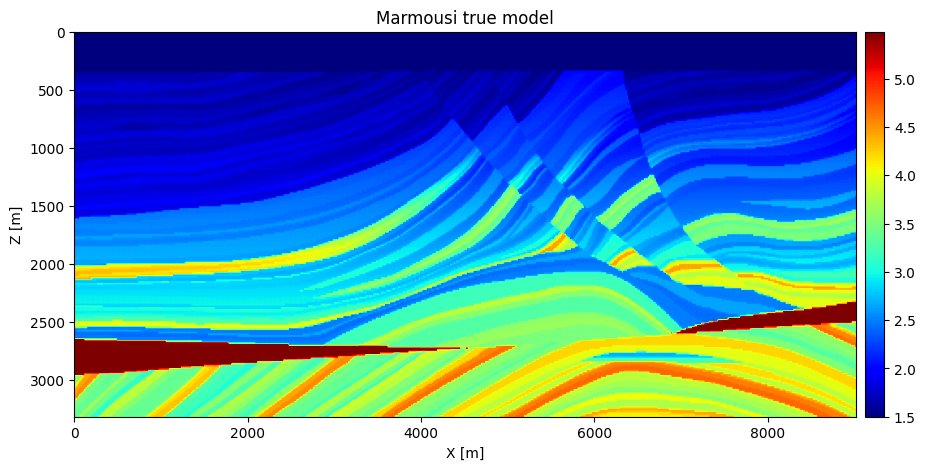

In [5]:
m_vmin, m_vmax = np.percentile(model_true, [2,98]) 
show_model(model_true, cmap='jet', vmin=m_vmin, vmax=m_vmax, figsize=(12, 5), extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0),
           title='Marmousi true model')

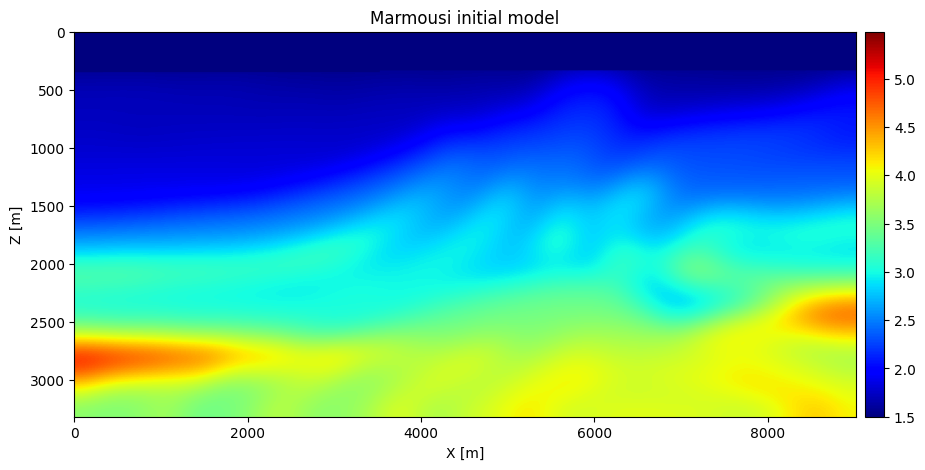

In [6]:
# Create initial guess model for inversion by smoothing the true model
model_init = sp.ndimage.gaussian_filter(model_true, sigma=[10,15])
model_init = model_init * mask
model_init[model_init==0] = 1.5 # km/s
model_init = model_init.astype(np.float32)
show_model(model_init, cmap='jet', vmin=m_vmin, vmax=m_vmax, figsize=(12, 5), extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0),
           title='Marmousi initial model')

In [7]:
# Create the source the wavelet
source_wavelet = deepwave.wavelets.ricker(par['freq'], par['nt'], par['dt'], 1/par['freq'])
# Initialize the FWI class
params = fwi.FWIParams(par, torch.tensor(source_wavelet), 1)
# Get the source receiver coordinates
x_s1, x_r1 = params.get_coordinate(1)
# Create a wavelet for every source
source_amplitudes = params.create_wavelet(torch.tensor(source_wavelet))

Text(0.5, 1.0, 'Source wavelet')

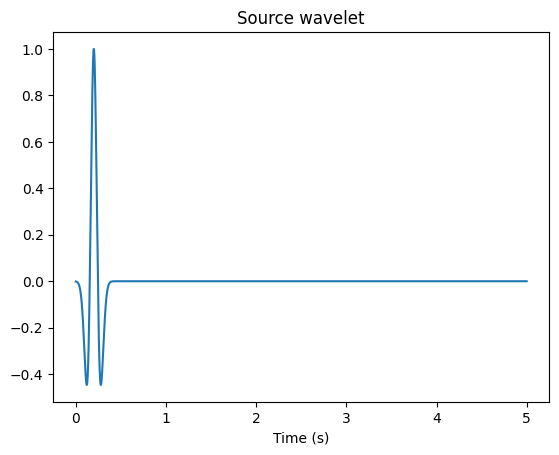

In [8]:
# Visualize the source wavelet
plt.plot(np.arange(0,par['nt'])*par['dt'], source_amplitudes[0,0,:])
plt.xlabel('Time (s)')
plt.title('Source wavelet')

In [9]:
# Simulate the true data
data_true = fwi.forward_modelling(params, torch.tensor(model_true).float(), device)

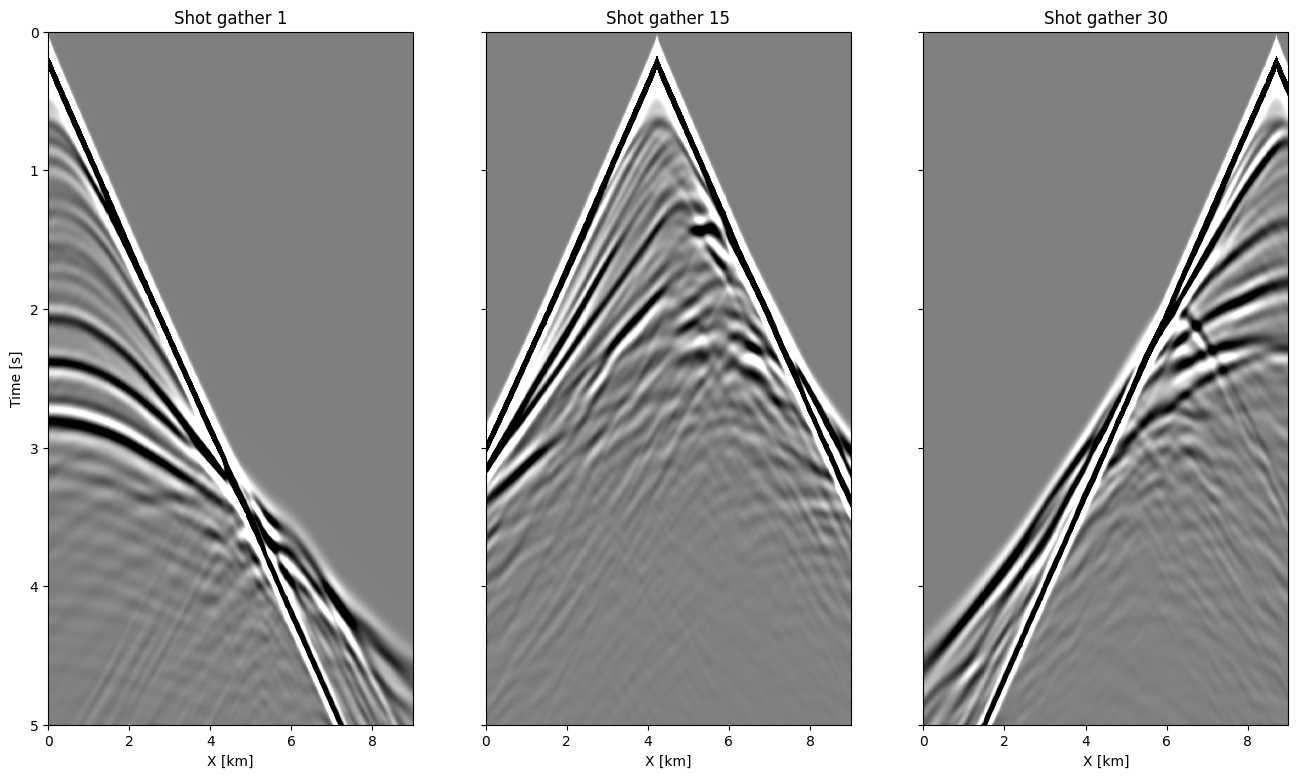

In [10]:
# Visualize the true data
show_3_shots(data_true.cpu(), [0, 14, 29], clip=0.01, extent=(0,int(par['nx']*par['dx']), int(par['nt']*par['dt']), 0), 
        ylim=(int(par['nt']*par['dt']), 0),)

## Run FWI with the Barzilai-Borwein method

In [11]:
# Create folder to save the results
exp_name = f'Exp_Marmousi_BB'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

In [15]:
# Run conventional FWI with the Barzilai-Borwein method

# Move data to GPU if using GPU
model = torch.tensor(model_init).clone().to(device)
model.requires_grad = True
data_true = torch.tensor(data_true).float()
mask = torch.tensor(mask).to(device)
# Create lists to save results
gradients, updates, fwi_loss, ssim_list, alphas = [], [], [], [], []

data_range = model_true.max() - model_true.min()
loss_fn = nn.MSELoss() # Misfit function for FWI
optimizer = torch.optim.SGD([{'params': [model], 'lr': 1e-1,}]) # Optimizer to run FWI with step size: lr
tsamples = 0 # Number of time samples starting from zero to exclude from computing the misfit
FWI_iter = 100 # Number of FWI iterations

t_start = time.time()
for iteration in tqdm(range(FWI_iter)):
    # Compute the structural similarity index measure (ssim) between the current and the true models
    ssim_metric = ssim(model.detach().cpu().numpy(), model_true, data_range=data_range)
    ssim_list.append(ssim_metric)
    # Compute FWI gradient
    optimizer.zero_grad()
    grad, iter_loss = fwi.compute_gradient(params, model, data_true, loss_fn, tsamples, device)
    fwi_loss.append(iter_loss)
    print(f'FWI iteration: {iteration} loss = {fwi_loss[-1]}, ssim = {ssim_list[-1]}')
    # Clip the gradient values
    torch.nn.utils.clip_grad_value_(model, torch.quantile(grad.detach().abs(), 0.98))

    if iteration == 0: gmax0 =  torch.abs(grad.detach()).max()
    # Normalize the gradient, mask it around the sources
    grad = (grad /gmax0) * mask
    gradients.append(grad.cpu().detach().numpy())
    # Calculate the step size
    if iteration > 0:
        delta_model = model.detach().clone() - previous_model
        delta_grad = grad.detach().clone() - previous_grad
        alpha = fwi.bb_step(delta_model, delta_grad, 'short')
        alphas.append(alpha)
        optimizer.param_groups[-1]['lr'] = alpha
    # Save the current solution and gradient for calculating the step size in the next iteration
    previous_model = model.detach().clone()
    previous_grad = grad.detach().clone()
    # Update the model
    model.grad.data[:] = grad
    optimizer.step()
    updates.append(model.detach().clone().cpu().numpy())
    # Plot the results
    # show_one_iter_fwi(grad.cpu(), model.detach().cpu(), iteration=iteration,
    #             cmap='bwr', vmin=m_vmin, vmax=m_vmax, extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0), save_path=f'{exp_name}')
t_end = time.time()
t_delta = t_end - t_start
print(f'Runtime:{datetime.timedelta(seconds=t_delta)}')

# Save the results
np.savez(f'{exp_name}/losses', fwi_loss=np.array(fwi_loss), ssim=np.array(ssim_list), alphas=np.array(alphas))
np.savez(f'{exp_name}/results', updates=np.array(updates), gradients=np.array(gradients) )

  0%|          | 0/100 [00:00<?, ?it/s]

FWI iteration: 0 loss = 1.4465602697531893e-13, ssim = 0.5929408504557789
FWI iteration: 1 loss = 1.2497888353383822e-13, ssim = 0.5938456526698751
FWI iteration: 2 loss = 8.849472103642937e-14, ssim = 0.5966243577763933
FWI iteration: 3 loss = 7.829095919199663e-14, ssim = 0.5986265571388012
FWI iteration: 4 loss = 7.322244820564573e-14, ssim = 0.5997268654014499
FWI iteration: 5 loss = 7.05691053010972e-14, ssim = 0.6006332804092005
FWI iteration: 6 loss = 6.695448921219636e-14, ssim = 0.6020856936302399
FWI iteration: 7 loss = 5.856918230933103e-14, ssim = 0.606319449200858
FWI iteration: 8 loss = 5.291045650657883e-14, ssim = 0.6109646566294425
FWI iteration: 9 loss = 5.124187817226629e-14, ssim = 0.6116655963609247
FWI iteration: 10 loss = 5.032913545828261e-14, ssim = 0.6121265613538602
FWI iteration: 11 loss = 4.9774761655198226e-14, ssim = 0.6125880280882618
FWI iteration: 12 loss = 4.541477995082295e-14, ssim = 0.6163127919206026
FWI iteration: 13 loss = 3.7556699783895696e-14

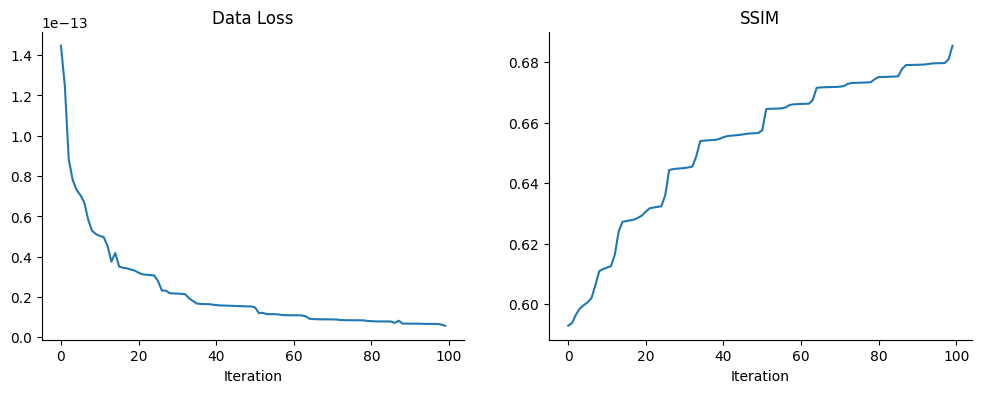

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(fwi_loss)
axs[0].set_title('Data Loss')
axs[0].set_xlabel('Iteration')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].plot(ssim_list)
axs[1].set_title('SSIM')
axs[1].set_xlabel('Iteration')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.savefig(f'{exp_name}/losses.png',  bbox_inches='tight', dpi=300)

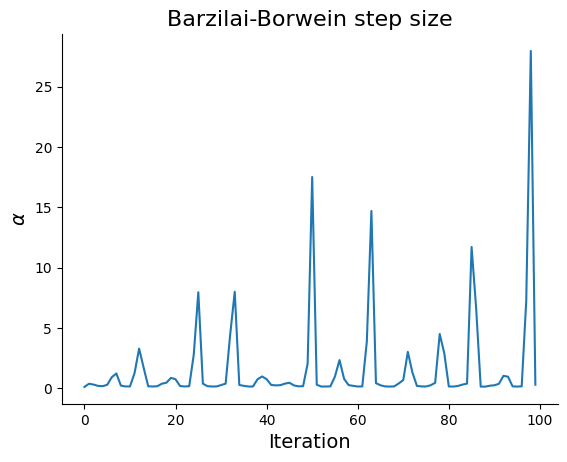

In [17]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(FWI_iter), np.concatenate([[1e-1], alphas]))
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel(r'$\alpha$', fontsize=14)
ax.set_title('Barzilai-Borwein step size', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(f'{exp_name}/alpha.png',  bbox_inches='tight', dpi=300)

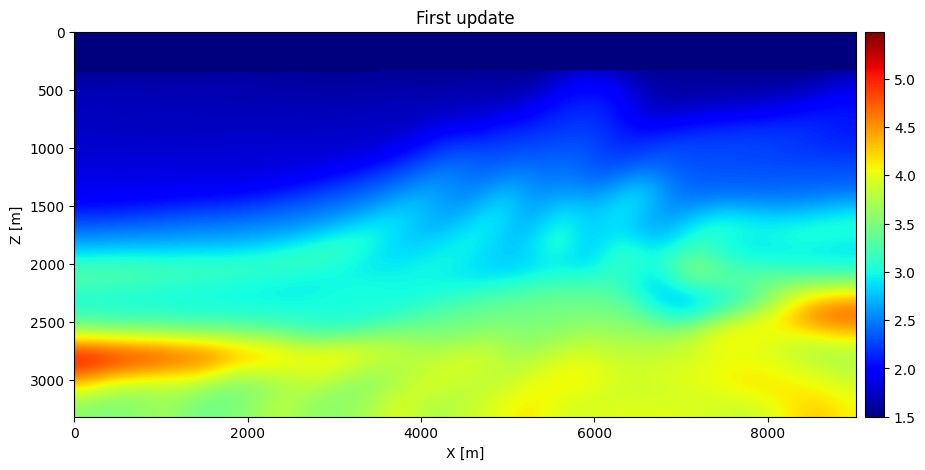

In [20]:
show_model(updates[0], cmap='jet', vmin=m_vmin, vmax=m_vmax, figsize=(12, 5), extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0),
           title='First update')

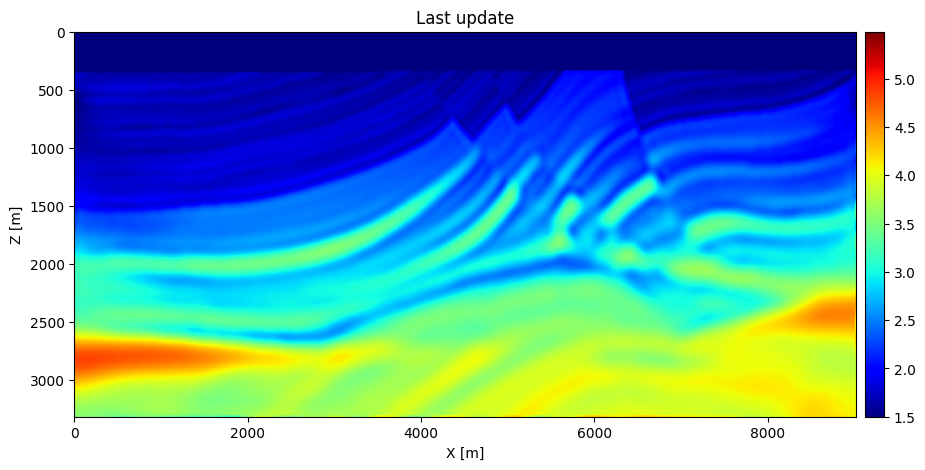

In [21]:
show_model(updates[-1], cmap='jet', vmin=m_vmin, vmax=m_vmax, figsize=(12, 5), extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0),
           title='Last update')

## Run FWI with the proposed approach $\delta m$

  0%|          | 0/30 [00:00<?, ?it/s]

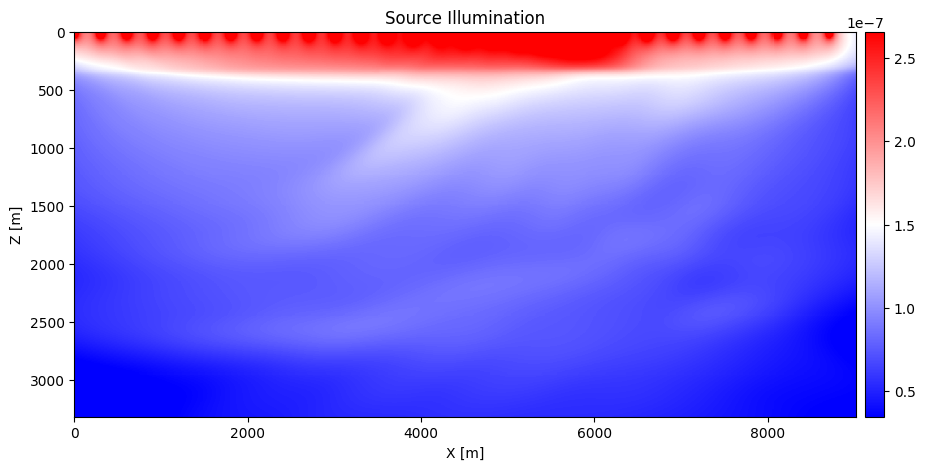

In [11]:
# Compute source illumination
SI = fwi.source_illumination(torch.tensor(model_init), source_amplitudes, par['dx'], par['dt'], x_s1, device=device)
# clear memory
torch.cuda.empty_cache()
gc.collect()
# Visualize the source illumination
simin, simax = np.percentile(SI.cpu(), [2,98])
show_model(SI.cpu(), cmap='bwr', vmin=simin, vmax=simax, figsize=(12, 5), extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0),
           title='Source Illumination')

In [12]:
# Create folder to save the results
exp_name = f'Exp_Marmousi_dm'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

In [13]:
# Run FWI with the proposed method

# Move data to GPU if using GPU
model = torch.tensor(model_init).clone().to(device)
model.requires_grad = True
data_true = torch.tensor(data_true).float()
mask = torch.tensor(mask).to(device)
# Create lists to save results
gradients, dm1s, gradients_pred, dms, updates, fwi_loss, ssim_list, network_loss = [], [], [], [], [], [], [], []

data_range = model_true.max() - model_true.min()
loss_fn = torch.nn.MSELoss() # Misfit function for FWI and Born modelling
optimizer = torch.optim.SGD([{'params': [model], 'lr': 1e-2}]) # Optimizer to run FWI with step size: lr
# Create the network, its optimizer and the loss function to train it
network = UNet(n_channels=1, n_classes=1, hidden_channels=128).to(device)
optimizer_unet = torch.optim.Adam(network.parameters(), lr=1e-4)
l2_norm = torch.nn.MSELoss()
network_iter_init = 1000 # Number of epochs to train the network in the first FWI iteration
network_iter_fin = 300 # Number of epochs to train the network in every FWI iteration except the first one
tsamples = 0 # Number of time samples starting from zero to exclude from computing the misfit
FWI_iter = 100 # Number of FWI iterations
t_start = time.time()
for iteration in tqdm(range(FWI_iter)):
    # Compute the structural similarity index measure (ssim) between the current and the true models
    ssim_metric = ssim(model.detach().cpu().numpy(), model_true, data_range=data_range)
    ssim_list.append(ssim_metric)
    # Compute FWI gradient
    optimizer.zero_grad()
    grad, iter_loss = fwi.compute_gradient(params, model, data_true, loss_fn, tsamples, device)
    fwi_loss.append(iter_loss)
    print(f'FWI iteration: {iteration} loss = {fwi_loss[-1]}, ssim = {ssim_list[-1]}')
    # Clip the gradient values
    torch.nn.utils.clip_grad_value_(model, torch.quantile(grad.detach().abs(), 0.98))
    # Apply source illumination to the gradient
    grad = (grad * model.detach().clone()**3 ) / SI
    if iteration == 0: gmax0 =  torch.abs(grad.detach()).max()
    # Normalize the gradient, mask it around the sources and apply taperinn to the shallower and deeper parts
    grad = (grad /gmax0) * mask
    gradients.append(grad.cpu().detach().numpy())
    # Compute dm1 with the gradient as the perturbation
    dm1 = grad.detach().clone().to(device)
    dm1.requires_grad = True
    dm1 = fwi.compute_dm1(params, model.detach().clone(), dm1 , loss_fn, tsamples, device)
    # Apply source illumination to dm1
    dm1 = dm1 * (model.detach().clone() ** 3) / SI
    if iteration == 0: dm1max0 =  1e1 * torch.abs(dm1.detach()).max()
    # Normalize dm1 and mask it around the sources
    dm1 = (dm1 / dm1max0)  * mask
    dm1s.append(dm1.cpu().detach().numpy())
    # Train the network
    training_pair = {'x': dm1.clone().unsqueeze(0).unsqueeze(0),
                    'y': grad.clone().unsqueeze(0).unsqueeze(0)}
    network_iter = network_iter_init if iteration == 0 else network_iter_fin
    lossn = train(network, training_pair, optimizer_unet, l2_norm, network_iter, use_scheduler=True, device=device)
    network_loss.extend(lossn)
    # Get the gradient from the network
    with torch.no_grad():
        g = network(training_pair['x']).squeeze() * mask
    gradients_pred.append(g.cpu().detach().numpy())
    # Get dm from the network
    with torch.no_grad():
        dm = network(training_pair['y']).squeeze() * mask
    dms.append(dm.cpu().detach().numpy())
    # Update the model
    model.grad.data[:] = dm.detach().clone()
    optimizer.step()
    updates.append(model.detach().clone().cpu().numpy())
    # Plot the results
    # show_one_iter_dm(grad.cpu(), dm1.cpu(), g.cpu(), dm.cpu(), model.detach().cpu(), lossn, iteration=iteration,
    #             cmap='bwr', vmin=m_vmin, vmax=m_vmax, extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0), save_path=f'{exp_name}')
t_end = time.time()
t_delta = t_end - t_start
print(f'Runtime:{datetime.timedelta(seconds=t_delta)}')
# Save the results
np.savez(f'{exp_name}/losses', fwi_loss=np.array(fwi_loss),
                               network_loss=np.array(network_loss),
                               ssim=np.array(ssim_list),
                               )
np.savez(f'{exp_name}/results', updates=np.array(updates), 
                            gradients=np.array(gradients), 
                            dm1s=np.array(dm1s),
                            gradients_pred=np.array(gradients_pred),
                            dms=np.array(dms),)
# Save the network weights
torch.save(network.state_dict(), f'{exp_name}/network_weights.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

FWI iteration: 0 loss = 1.4465602697531893e-13, ssim = 0.5929408504557789


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.027595723047852516
Training Epoch 1, Loss = 0.026424819603562355
Training Epoch 2, Loss = 0.025294406339526176
Training Epoch 3, Loss = 0.02407211624085903
Training Epoch 4, Loss = 0.02276913821697235
Training Epoch 5, Loss = 0.021332086995244026
Training Epoch 6, Loss = 0.019791582599282265
Training Epoch 7, Loss = 0.01823810115456581
Training Epoch 8, Loss = 0.01686173491179943
Training Epoch 9, Loss = 0.01615925505757332
Training Epoch 10, Loss = 0.01656774803996086
Training Epoch 11, Loss = 0.016400791704654694
Training Epoch 12, Loss = 0.015524359419941902
Training Epoch 13, Loss = 0.014435160905122757
Training Epoch 14, Loss = 0.013418846763670444
Training Epoch 15, Loss = 0.012557487934827805
Training Epoch 16, Loss = 0.011842717416584492
Training Epoch 17, Loss = 0.011239401064813137
Training Epoch 18, Loss = 0.010725922882556915
Training Epoch 19, Loss = 0.01031035277992487
Training Epoch 20, Loss = 0.010005836375057697
Training Epoch 21, Loss = 0.00

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.01840939372777939
Training Epoch 1, Loss = 0.011430402286350727
Training Epoch 2, Loss = 0.006943734362721443
Training Epoch 3, Loss = 0.00546304089948535
Training Epoch 4, Loss = 0.005186384543776512
Training Epoch 5, Loss = 0.0050405943766236305
Training Epoch 6, Loss = 0.004865344613790512
Training Epoch 7, Loss = 0.004741337615996599
Training Epoch 8, Loss = 0.004675458651036024
Training Epoch 9, Loss = 0.004626019392162561
Training Epoch 10, Loss = 0.004562576301395893
Training Epoch 11, Loss = 0.004470234736800194
Training Epoch 12, Loss = 0.004356248304247856
Training Epoch 13, Loss = 0.004237103741616011
Training Epoch 14, Loss = 0.004130595363676548
Training Epoch 15, Loss = 0.0040477849543094635
Training Epoch 16, Loss = 0.00399264320731163
Training Epoch 17, Loss = 0.003957326523959637
Training Epoch 18, Loss = 0.003913142252713442
Training Epoch 19, Loss = 0.0038294349797070026
Training Epoch 20, Loss = 0.0037100850604474545
Training Epoch 21, Los

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.002874379977583885
Training Epoch 1, Loss = 0.002665668958798051
Training Epoch 2, Loss = 0.0023530616890639067
Training Epoch 3, Loss = 0.0020552650094032288
Training Epoch 4, Loss = 0.0018420226406306028
Training Epoch 5, Loss = 0.0017192448722198606
Training Epoch 6, Loss = 0.0016601075185462832
Training Epoch 7, Loss = 0.0016324571333825588
Training Epoch 8, Loss = 0.0016098925843834877
Training Epoch 9, Loss = 0.001576450653374195
Training Epoch 10, Loss = 0.0015221794601529837
Training Epoch 11, Loss = 0.001449689152650535
Training Epoch 12, Loss = 0.0013780476292595267
Training Epoch 13, Loss = 0.0013245585141703486
Training Epoch 14, Loss = 0.0012820482952520251
Training Epoch 15, Loss = 0.0012325594434514642
Training Epoch 16, Loss = 0.0011737179011106491
Training Epoch 17, Loss = 0.0011177153792232275
Training Epoch 18, Loss = 0.001073948573321104
Training Epoch 19, Loss = 0.0010408101370558143
Training Epoch 20, Loss = 0.0010111068841069937
Trainin

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.3104709982872009
Training Epoch 1, Loss = 0.10010302811861038
Training Epoch 2, Loss = 0.03779543936252594
Training Epoch 3, Loss = 0.017098652198910713
Training Epoch 4, Loss = 0.012330295518040657
Training Epoch 5, Loss = 0.012531477026641369
Training Epoch 6, Loss = 0.01375827006995678
Training Epoch 7, Loss = 0.013559726066887379
Training Epoch 8, Loss = 0.012108055874705315
Training Epoch 9, Loss = 0.010323639027774334
Training Epoch 10, Loss = 0.008765622042119503
Training Epoch 11, Loss = 0.007619052194058895
Training Epoch 12, Loss = 0.006851095240563154
Training Epoch 13, Loss = 0.006357831880450249
Training Epoch 14, Loss = 0.0060445573180913925
Training Epoch 15, Loss = 0.005843461956828833
Training Epoch 16, Loss = 0.005710958503186703
Training Epoch 17, Loss = 0.00561976432800293
Training Epoch 18, Loss = 0.005553589668124914
Training Epoch 19, Loss = 0.005503705237060785
Training Epoch 20, Loss = 0.005464256275445223
Training Epoch 21, Loss = 0.

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0046224636025726795
Training Epoch 1, Loss = 0.004551253747195005
Training Epoch 2, Loss = 0.004436170682311058
Training Epoch 3, Loss = 0.004305871203541756
Training Epoch 4, Loss = 0.004178164526820183
Training Epoch 5, Loss = 0.004060273990035057
Training Epoch 6, Loss = 0.003953842446208
Training Epoch 7, Loss = 0.0038577388040721416
Training Epoch 8, Loss = 0.0037717039231210947
Training Epoch 9, Loss = 0.0036951040383428335
Training Epoch 10, Loss = 0.003626932855695486
Training Epoch 11, Loss = 0.003565619233995676
Training Epoch 12, Loss = 0.0035109524615108967
Training Epoch 13, Loss = 0.003462855238467455
Training Epoch 14, Loss = 0.003420212073251605
Training Epoch 15, Loss = 0.003382393391802907
Training Epoch 16, Loss = 0.003349479055032134
Training Epoch 17, Loss = 0.003321137046441436
Training Epoch 18, Loss = 0.003296968527138233
Training Epoch 19, Loss = 0.003276138799265027
Training Epoch 20, Loss = 0.0032583053689450026
Training Epoch 21, L

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.003205598331987858
Training Epoch 1, Loss = 0.003125872928649187
Training Epoch 2, Loss = 0.0030820267274975777
Training Epoch 3, Loss = 0.0029889894649386406
Training Epoch 4, Loss = 0.0028902883641421795
Training Epoch 5, Loss = 0.0028342860750854015
Training Epoch 6, Loss = 0.0027784646954387426
Training Epoch 7, Loss = 0.002718412084504962
Training Epoch 8, Loss = 0.002670787740498781
Training Epoch 9, Loss = 0.002631432143971324
Training Epoch 10, Loss = 0.0025906001683324575
Training Epoch 11, Loss = 0.0025541249196976423
Training Epoch 12, Loss = 0.0025293671060353518
Training Epoch 13, Loss = 0.0025105089880526066
Training Epoch 14, Loss = 0.0024893353693187237
Training Epoch 15, Loss = 0.002466963604092598
Training Epoch 16, Loss = 0.0024487897753715515
Training Epoch 17, Loss = 0.002433823887258768
Training Epoch 18, Loss = 0.0024173588026314974
Training Epoch 19, Loss = 0.002399106975644827
Training Epoch 20, Loss = 0.002382409293204546
Training Ep

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0017207369673997164
Training Epoch 1, Loss = 0.001710421172901988
Training Epoch 2, Loss = 0.0016946616815403104
Training Epoch 3, Loss = 0.00167925248388201
Training Epoch 4, Loss = 0.0016681207343935966
Training Epoch 5, Loss = 0.0016620754031464458
Training Epoch 6, Loss = 0.001658744877204299
Training Epoch 7, Loss = 0.0016545660328119993
Training Epoch 8, Loss = 0.0016473301220685244
Training Epoch 9, Loss = 0.0016373858088627458
Training Epoch 10, Loss = 0.001626579905860126
Training Epoch 11, Loss = 0.001616657362319529
Training Epoch 12, Loss = 0.0016081721987575293
Training Epoch 13, Loss = 0.0016009464161470532
Training Epoch 14, Loss = 0.0015945349587127566
Training Epoch 15, Loss = 0.0015886082546785474
Training Epoch 16, Loss = 0.0015832684002816677
Training Epoch 17, Loss = 0.0015785328578203917
Training Epoch 18, Loss = 0.0015740536618977785
Training Epoch 19, Loss = 0.0015693233581259847
Training Epoch 20, Loss = 0.001564131467603147
Training 

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0014410187723115087
Training Epoch 1, Loss = 0.001435262500308454
Training Epoch 2, Loss = 0.0014268894447013736
Training Epoch 3, Loss = 0.0014183355960994959
Training Epoch 4, Loss = 0.001410221098922193
Training Epoch 5, Loss = 0.0014021064853295684
Training Epoch 6, Loss = 0.0013936979230493307
Training Epoch 7, Loss = 0.001385162933729589
Training Epoch 8, Loss = 0.0013771525118499994
Training Epoch 9, Loss = 0.00137026933953166
Training Epoch 10, Loss = 0.001364553696475923
Training Epoch 11, Loss = 0.0013595940545201302
Training Epoch 12, Loss = 0.0013548952993005514
Training Epoch 13, Loss = 0.0013503899099305272
Training Epoch 14, Loss = 0.001346145523712039
Training Epoch 15, Loss = 0.0013421418843790889
Training Epoch 16, Loss = 0.001338345929980278
Training Epoch 17, Loss = 0.0013346753548830748
Training Epoch 18, Loss = 0.0013310408685356379
Training Epoch 19, Loss = 0.0013273281510919333
Training Epoch 20, Loss = 0.0013234842335805297
Training E

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0010107842972502112
Training Epoch 1, Loss = 0.0010074919555336237
Training Epoch 2, Loss = 0.0010054736630991101
Training Epoch 3, Loss = 0.0010052864672616124
Training Epoch 4, Loss = 0.00100353779271245
Training Epoch 5, Loss = 0.0010010949335992336
Training Epoch 6, Loss = 0.0010000842157751322
Training Epoch 7, Loss = 0.000999331008642912
Training Epoch 8, Loss = 0.0009979119058698416
Training Epoch 9, Loss = 0.0009966513607650995
Training Epoch 10, Loss = 0.000995742972008884
Training Epoch 11, Loss = 0.000994632369838655
Training Epoch 12, Loss = 0.0009931991808116436
Training Epoch 13, Loss = 0.0009920361917465925
Training Epoch 14, Loss = 0.0009911294328048825
Training Epoch 15, Loss = 0.0009901170851662755
Training Epoch 16, Loss = 0.0009890225483104587
Training Epoch 17, Loss = 0.0009881622390821576
Training Epoch 18, Loss = 0.0009874594397842884
Training Epoch 19, Loss = 0.0009864564053714275
Training Epoch 20, Loss = 0.0009854525560513139
Trainin

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0008663880289532244
Training Epoch 1, Loss = 0.0008505670120939612
Training Epoch 2, Loss = 0.0008433517068624496
Training Epoch 3, Loss = 0.0008449386223219335
Training Epoch 4, Loss = 0.0008390680886805058
Training Epoch 5, Loss = 0.0008283651550300419
Training Epoch 6, Loss = 0.0008240186725743115
Training Epoch 7, Loss = 0.000823533977381885
Training Epoch 8, Loss = 0.000821219349745661
Training Epoch 9, Loss = 0.000817023275885731
Training Epoch 10, Loss = 0.0008142681326717138
Training Epoch 11, Loss = 0.0008119572303257883
Training Epoch 12, Loss = 0.0008098683319985867
Training Epoch 13, Loss = 0.0008085307199507952
Training Epoch 14, Loss = 0.0008064936846494675
Training Epoch 15, Loss = 0.0008036880171857774
Training Epoch 16, Loss = 0.0008024320122785866
Training Epoch 17, Loss = 0.0008018913213163614
Training Epoch 18, Loss = 0.0007995828636921942
Training Epoch 19, Loss = 0.0007967563578858972
Training Epoch 20, Loss = 0.0007958788773976266
Train

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0008396927150897682
Training Epoch 1, Loss = 0.0008059365209192038
Training Epoch 2, Loss = 0.0007836628938093781
Training Epoch 3, Loss = 0.0007851053378544748
Training Epoch 4, Loss = 0.0007721553556621075
Training Epoch 5, Loss = 0.0007464088266715407
Training Epoch 6, Loss = 0.00073769292794168
Training Epoch 7, Loss = 0.0007402740302495658
Training Epoch 8, Loss = 0.000736957706976682
Training Epoch 9, Loss = 0.0007253653020597994
Training Epoch 10, Loss = 0.0007194194477051497
Training Epoch 11, Loss = 0.000720743730198592
Training Epoch 12, Loss = 0.0007178569212555885
Training Epoch 13, Loss = 0.0007113488973118365
Training Epoch 14, Loss = 0.0007046423270367086
Training Epoch 15, Loss = 0.0007037172908894718
Training Epoch 16, Loss = 0.0007023656507954001
Training Epoch 17, Loss = 0.0006971709663048387
Training Epoch 18, Loss = 0.0006927644717507064
Training Epoch 19, Loss = 0.0006917687132954597
Training Epoch 20, Loss = 0.0006919738370925188
Traini

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0024204300716519356
Training Epoch 1, Loss = 0.002105199731886387
Training Epoch 2, Loss = 0.0017946887528523803
Training Epoch 3, Loss = 0.001595955342054367
Training Epoch 4, Loss = 0.0014869400765746832
Training Epoch 5, Loss = 0.0013826725771650672
Training Epoch 6, Loss = 0.0013150239828974009
Training Epoch 7, Loss = 0.0012634843587875366
Training Epoch 8, Loss = 0.0012166147353127599
Training Epoch 9, Loss = 0.0011821442749351263
Training Epoch 10, Loss = 0.0011553321965038776
Training Epoch 11, Loss = 0.0011327812680974603
Training Epoch 12, Loss = 0.0011168756755068898
Training Epoch 13, Loss = 0.0011032188776880503
Training Epoch 14, Loss = 0.0010874704457819462
Training Epoch 15, Loss = 0.0010747372871264815
Training Epoch 16, Loss = 0.001064798911102116
Training Epoch 17, Loss = 0.001050156308338046
Training Epoch 18, Loss = 0.0010321077425032854
Training Epoch 19, Loss = 0.0010177771328017116
Training Epoch 20, Loss = 0.0010066134855151176
Traini

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0008842502138577402
Training Epoch 1, Loss = 0.0009445953764952719
Training Epoch 2, Loss = 0.001648814883083105
Training Epoch 3, Loss = 0.0021636695601046085
Training Epoch 4, Loss = 0.0009418109548278153
Training Epoch 5, Loss = 0.0013718771515414119
Training Epoch 6, Loss = 0.0011219519656151533
Training Epoch 7, Loss = 0.0011562105501070619
Training Epoch 8, Loss = 0.0011132986983284354
Training Epoch 9, Loss = 0.0009832300711423159
Training Epoch 10, Loss = 0.0009233311866410077
Training Epoch 11, Loss = 0.0009725817362777889
Training Epoch 12, Loss = 0.0010317808482795954
Training Epoch 13, Loss = 0.001013646018691361
Training Epoch 14, Loss = 0.0009510591626167297
Training Epoch 15, Loss = 0.0009097939473576844
Training Epoch 16, Loss = 0.0008948868489824235
Training Epoch 17, Loss = 0.0008773505687713623
Training Epoch 18, Loss = 0.0008509696344844997
Training Epoch 19, Loss = 0.0008326761890202761
Training Epoch 20, Loss = 0.0008307195967063308
Trai

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00040582206565886736
Training Epoch 1, Loss = 0.00040409876964986324
Training Epoch 2, Loss = 0.0004028927651233971
Training Epoch 3, Loss = 0.0004014022124465555
Training Epoch 4, Loss = 0.00040073751006275415
Training Epoch 5, Loss = 0.00039831778849475086
Training Epoch 6, Loss = 0.00039771926822140813
Training Epoch 7, Loss = 0.0003965565701946616
Training Epoch 8, Loss = 0.0003960166359320283
Training Epoch 9, Loss = 0.000394638191210106
Training Epoch 10, Loss = 0.00039400585228577256
Training Epoch 11, Loss = 0.00039340517832897604
Training Epoch 12, Loss = 0.0003925010678358376
Training Epoch 13, Loss = 0.00039165164344012737
Training Epoch 14, Loss = 0.0003909353690687567
Training Epoch 15, Loss = 0.0003904230834450573
Training Epoch 16, Loss = 0.0003895368135999888
Training Epoch 17, Loss = 0.00038891745498403907
Training Epoch 18, Loss = 0.0003882442251779139
Training Epoch 19, Loss = 0.0003877691924571991
Training Epoch 20, Loss = 0.00038702669553

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00032545794965699315
Training Epoch 1, Loss = 0.0003235182957723737
Training Epoch 2, Loss = 0.00032268950599245727
Training Epoch 3, Loss = 0.0003225386899430305
Training Epoch 4, Loss = 0.0003307343868073076
Training Epoch 5, Loss = 0.00036613279371522367
Training Epoch 6, Loss = 0.00047470832942053676
Training Epoch 7, Loss = 0.0006290563615038991
Training Epoch 8, Loss = 0.0005558310658670962
Training Epoch 9, Loss = 0.00031794243841432035
Training Epoch 10, Loss = 0.0004527138371486217
Training Epoch 11, Loss = 0.00039996791747398674
Training Epoch 12, Loss = 0.0003519657766446471
Training Epoch 13, Loss = 0.0004043838707730174
Training Epoch 14, Loss = 0.00032828430994413793
Training Epoch 15, Loss = 0.000385970895877108
Training Epoch 16, Loss = 0.0003244492399971932
Training Epoch 17, Loss = 0.00036692930734716356
Training Epoch 18, Loss = 0.00032433311571367085
Training Epoch 19, Loss = 0.0003469842195045203
Training Epoch 20, Loss = 0.00032870634458

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0003189885464962572
Training Epoch 1, Loss = 0.00031125888926908374
Training Epoch 2, Loss = 0.0003124740906059742
Training Epoch 3, Loss = 0.0003109232638962567
Training Epoch 4, Loss = 0.0003050701634492725
Training Epoch 5, Loss = 0.00030544097535312176
Training Epoch 6, Loss = 0.0003034956753253937
Training Epoch 7, Loss = 0.000299345439998433
Training Epoch 8, Loss = 0.00029983927379362285
Training Epoch 9, Loss = 0.0002990460197906941
Training Epoch 10, Loss = 0.00029565466684289277
Training Epoch 11, Loss = 0.00029541351250372827
Training Epoch 12, Loss = 0.0002958820550702512
Training Epoch 13, Loss = 0.00029308602097444236
Training Epoch 14, Loss = 0.0002918860118370503
Training Epoch 15, Loss = 0.00029217053088359535
Training Epoch 16, Loss = 0.00029042261303402483
Training Epoch 17, Loss = 0.00028903086786158383
Training Epoch 18, Loss = 0.00028902589110657573
Training Epoch 19, Loss = 0.00028817742713727057
Training Epoch 20, Loss = 0.000286528666

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00029720511520281434
Training Epoch 1, Loss = 0.00031175388721749187
Training Epoch 2, Loss = 0.0004132301255594939
Training Epoch 3, Loss = 0.0008586739422753453
Training Epoch 4, Loss = 0.001552520552650094
Training Epoch 5, Loss = 0.0005012142355553806
Training Epoch 6, Loss = 0.0007443734211847186
Training Epoch 7, Loss = 0.0004753622051794082
Training Epoch 8, Loss = 0.0006652468000538647
Training Epoch 9, Loss = 0.00037166636320762336
Training Epoch 10, Loss = 0.0005121545400470495
Training Epoch 11, Loss = 0.0005130809731781483
Training Epoch 12, Loss = 0.00036696388269774616
Training Epoch 13, Loss = 0.0004114670737180859
Training Epoch 14, Loss = 0.00045687000965699553
Training Epoch 15, Loss = 0.0003821369609795511
Training Epoch 16, Loss = 0.0003423661692067981
Training Epoch 17, Loss = 0.00037857386632822454
Training Epoch 18, Loss = 0.0003912711108569056
Training Epoch 19, Loss = 0.0003559027099981904
Training Epoch 20, Loss = 0.00032798506435938

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00029658168205060065
Training Epoch 1, Loss = 0.0002982891455758363
Training Epoch 2, Loss = 0.0003480881860014051
Training Epoch 3, Loss = 0.0005785823450423777
Training Epoch 4, Loss = 0.0014032776234671474
Training Epoch 5, Loss = 0.0014103922294452786
Training Epoch 6, Loss = 0.0003782913845498115
Training Epoch 7, Loss = 0.0008042347617447376
Training Epoch 8, Loss = 0.00040477339643985033
Training Epoch 9, Loss = 0.0005527716130018234
Training Epoch 10, Loss = 0.000622412480879575
Training Epoch 11, Loss = 0.0004424737999215722
Training Epoch 12, Loss = 0.0004314155667088926
Training Epoch 13, Loss = 0.0005057607195340097
Training Epoch 14, Loss = 0.00045166516792960465
Training Epoch 15, Loss = 0.00039624495548196137
Training Epoch 16, Loss = 0.0004240439448039979
Training Epoch 17, Loss = 0.0004420406767167151
Training Epoch 18, Loss = 0.0003978750901296735
Training Epoch 19, Loss = 0.00036045481101609766
Training Epoch 20, Loss = 0.000388859072700142

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00020290333486627787
Training Epoch 1, Loss = 0.00019948641420342028
Training Epoch 2, Loss = 0.000197974790353328
Training Epoch 3, Loss = 0.00019826342759188265
Training Epoch 4, Loss = 0.00019679777324199677
Training Epoch 5, Loss = 0.0001948429417097941
Training Epoch 6, Loss = 0.00019448348029982299
Training Epoch 7, Loss = 0.00019416020950302482
Training Epoch 8, Loss = 0.00019293371587991714
Training Epoch 9, Loss = 0.00019212259212508798
Training Epoch 10, Loss = 0.0001919410569826141
Training Epoch 11, Loss = 0.00019154766050633043
Training Epoch 12, Loss = 0.00019084537052549422
Training Epoch 13, Loss = 0.00019026006339117885
Training Epoch 14, Loss = 0.00018986605573445559
Training Epoch 15, Loss = 0.00018949032528325915
Training Epoch 16, Loss = 0.0001890401035780087
Training Epoch 17, Loss = 0.00018861572607420385
Training Epoch 18, Loss = 0.00018831128545571119
Training Epoch 19, Loss = 0.00018801951955538243
Training Epoch 20, Loss = 0.0001876

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00016721131396479905
Training Epoch 1, Loss = 0.00016604222764726728
Training Epoch 2, Loss = 0.00016597678768448532
Training Epoch 3, Loss = 0.00016548327403143048
Training Epoch 4, Loss = 0.0001646522869123146
Training Epoch 5, Loss = 0.00016434109420515597
Training Epoch 6, Loss = 0.00016401436005253345
Training Epoch 7, Loss = 0.00016343044990208
Training Epoch 8, Loss = 0.0001631645718589425
Training Epoch 9, Loss = 0.00016292867076117545
Training Epoch 10, Loss = 0.0001623642456252128
Training Epoch 11, Loss = 0.00016212192713283002
Training Epoch 12, Loss = 0.00016198831144720316
Training Epoch 13, Loss = 0.0001616064109839499
Training Epoch 14, Loss = 0.00016138219507411122
Training Epoch 15, Loss = 0.00016122142551466823
Training Epoch 16, Loss = 0.00016097001207526773
Training Epoch 17, Loss = 0.00016075983876362443
Training Epoch 18, Loss = 0.00016062713984865695
Training Epoch 19, Loss = 0.00016041110211517662
Training Epoch 20, Loss = 0.000160211

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00014979386469349265
Training Epoch 1, Loss = 0.00014870023005641997
Training Epoch 2, Loss = 0.00014846479461994022
Training Epoch 3, Loss = 0.00014792401634622365
Training Epoch 4, Loss = 0.00014746049419045448
Training Epoch 5, Loss = 0.00014742212078999728
Training Epoch 6, Loss = 0.00014738003665115684
Training Epoch 7, Loss = 0.0001477134646847844
Training Epoch 8, Loss = 0.00014865938283037394
Training Epoch 9, Loss = 0.0001503008243162185
Training Epoch 10, Loss = 0.00015331790200434625
Training Epoch 11, Loss = 0.00015831287601031363
Training Epoch 12, Loss = 0.00016452786803711206
Training Epoch 13, Loss = 0.00017118688265327364
Training Epoch 14, Loss = 0.00017325162480119616
Training Epoch 15, Loss = 0.00016804506594780833
Training Epoch 16, Loss = 0.000156987807713449
Training Epoch 17, Loss = 0.00014860877126920968
Training Epoch 18, Loss = 0.00014765982632525265
Training Epoch 19, Loss = 0.0001502851227996871
Training Epoch 20, Loss = 0.0001496

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00014799322525504977
Training Epoch 1, Loss = 0.00014508739695884287
Training Epoch 2, Loss = 0.00014369501150213182
Training Epoch 3, Loss = 0.000143658064189367
Training Epoch 4, Loss = 0.00014276262663770467
Training Epoch 5, Loss = 0.00014093308709561825
Training Epoch 6, Loss = 0.00014042120892554522
Training Epoch 7, Loss = 0.00014042295515537262
Training Epoch 8, Loss = 0.00013887824025005102
Training Epoch 9, Loss = 0.0001380621106363833
Training Epoch 10, Loss = 0.00013785298506263644
Training Epoch 11, Loss = 0.00013685923477169126
Training Epoch 12, Loss = 0.00013635536015499383
Training Epoch 13, Loss = 0.0001359161251457408
Training Epoch 14, Loss = 0.0001355389249511063
Training Epoch 15, Loss = 0.00013516642502509058
Training Epoch 16, Loss = 0.00013444667274598032
Training Epoch 17, Loss = 0.00013446596858557314
Training Epoch 18, Loss = 0.0001342555187875405
Training Epoch 19, Loss = 0.00013354796101339161
Training Epoch 20, Loss = 0.00013351

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00017919490346685052
Training Epoch 1, Loss = 0.0001560748351039365
Training Epoch 2, Loss = 0.0001741785235935822
Training Epoch 3, Loss = 0.0001539290533401072
Training Epoch 4, Loss = 0.00016062127542681992
Training Epoch 5, Loss = 0.0001565289421705529
Training Epoch 6, Loss = 0.00014968121831770986
Training Epoch 7, Loss = 0.00015620265912730247
Training Epoch 8, Loss = 0.00014354393351823092
Training Epoch 9, Loss = 0.00015164293290581554
Training Epoch 10, Loss = 0.0001431372220395133
Training Epoch 11, Loss = 0.0001442095817765221
Training Epoch 12, Loss = 0.0001436431921320036
Training Epoch 13, Loss = 0.00013895198935642838
Training Epoch 14, Loss = 0.0001431808341294527
Training Epoch 15, Loss = 0.00013646083243656904
Training Epoch 16, Loss = 0.00013959311763755977
Training Epoch 17, Loss = 0.00013649793982040137
Training Epoch 18, Loss = 0.0001359935849905014
Training Epoch 19, Loss = 0.00013645431317854673
Training Epoch 20, Loss = 0.00013360592

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00014181280857883394
Training Epoch 1, Loss = 0.000137212555273436
Training Epoch 2, Loss = 0.00013556376507040113
Training Epoch 3, Loss = 0.00014117930550128222
Training Epoch 4, Loss = 0.00016961616347543895
Training Epoch 5, Loss = 0.000280421954812482
Training Epoch 6, Loss = 0.000536402512807399
Training Epoch 7, Loss = 0.0007566175772808492
Training Epoch 8, Loss = 0.00035105604911223054
Training Epoch 9, Loss = 0.0003674690960906446
Training Epoch 10, Loss = 0.00038276490522548556
Training Epoch 11, Loss = 0.0001926786790136248
Training Epoch 12, Loss = 0.00035494790063239634
Training Epoch 13, Loss = 0.00015860389976296574
Training Epoch 14, Loss = 0.0002803596144076437
Training Epoch 15, Loss = 0.0001810412941267714
Training Epoch 16, Loss = 0.00020608615886885673
Training Epoch 17, Loss = 0.00021502080198843032
Training Epoch 18, Loss = 0.000156776761286892
Training Epoch 19, Loss = 0.00021204445511102676
Training Epoch 20, Loss = 0.000162713433383

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00011606651241891086
Training Epoch 1, Loss = 0.00011384279787307605
Training Epoch 2, Loss = 0.00011327829997753724
Training Epoch 3, Loss = 0.00011368223204044625
Training Epoch 4, Loss = 0.00011226202332181856
Training Epoch 5, Loss = 0.00011072916822740808
Training Epoch 6, Loss = 0.00011128986807307228
Training Epoch 7, Loss = 0.00011052088666474447
Training Epoch 8, Loss = 0.00010953966557281092
Training Epoch 9, Loss = 0.00010923669469775632
Training Epoch 10, Loss = 0.00010924901289399713
Training Epoch 11, Loss = 0.00010834128624992445
Training Epoch 12, Loss = 0.00010802606266224757
Training Epoch 13, Loss = 0.00010780486627481878
Training Epoch 14, Loss = 0.00010755689436336979
Training Epoch 15, Loss = 0.0001069330028258264
Training Epoch 16, Loss = 0.00010677780664991587
Training Epoch 17, Loss = 0.00010655946971382946
Training Epoch 18, Loss = 0.00010622329864418134
Training Epoch 19, Loss = 0.00010582499817246571
Training Epoch 20, Loss = 0.000

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00013305124593898654
Training Epoch 1, Loss = 0.00013061049685347825
Training Epoch 2, Loss = 0.0001279094722121954
Training Epoch 3, Loss = 0.0001271130022360012
Training Epoch 4, Loss = 0.0001252747024409473
Training Epoch 5, Loss = 0.00012368676834739745
Training Epoch 6, Loss = 0.00012187930406071246
Training Epoch 7, Loss = 0.0001213502764585428
Training Epoch 8, Loss = 0.00011982884461758658
Training Epoch 9, Loss = 0.00011830186122097075
Training Epoch 10, Loss = 0.0001176523364847526
Training Epoch 11, Loss = 0.00011674759298330173
Training Epoch 12, Loss = 0.00011599405843298882
Training Epoch 13, Loss = 0.00011473628546809778
Training Epoch 14, Loss = 0.00011405700206523761
Training Epoch 15, Loss = 0.00011318581528030336
Training Epoch 16, Loss = 0.0001123170877690427
Training Epoch 17, Loss = 0.00011167618504259735
Training Epoch 18, Loss = 0.00011101808195235208
Training Epoch 19, Loss = 0.00011045650899177417
Training Epoch 20, Loss = 0.00010977

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0001661651476752013
Training Epoch 1, Loss = 0.00015435584646183997
Training Epoch 2, Loss = 0.00015186003292910755
Training Epoch 3, Loss = 0.0001513832830823958
Training Epoch 4, Loss = 0.0001441511558368802
Training Epoch 5, Loss = 0.0001441829081159085
Training Epoch 6, Loss = 0.00014140621351543814
Training Epoch 7, Loss = 0.00013710689381696284
Training Epoch 8, Loss = 0.0001371303224004805
Training Epoch 9, Loss = 0.0001327788777416572
Training Epoch 10, Loss = 0.00013120556832291186
Training Epoch 11, Loss = 0.00013126693374942988
Training Epoch 12, Loss = 0.00012774656352121383
Training Epoch 13, Loss = 0.0001268914493266493
Training Epoch 14, Loss = 0.00012592568236868829
Training Epoch 15, Loss = 0.0001238230470335111
Training Epoch 16, Loss = 0.0001231331698363647
Training Epoch 17, Loss = 0.00012192617577966303
Training Epoch 18, Loss = 0.00012085115304216743
Training Epoch 19, Loss = 0.00012005187454633415
Training Epoch 20, Loss = 0.00011919647

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00017999988631345332
Training Epoch 1, Loss = 0.00016999547369778156
Training Epoch 2, Loss = 0.00015939658624120057
Training Epoch 3, Loss = 0.00015597538731526583
Training Epoch 4, Loss = 0.00015336323122028261
Training Epoch 5, Loss = 0.00015012770018074661
Training Epoch 6, Loss = 0.00014517722593154758
Training Epoch 7, Loss = 0.00014210656809154898
Training Epoch 8, Loss = 0.0001396767038386315
Training Epoch 9, Loss = 0.00013698439579457045
Training Epoch 10, Loss = 0.00013362588651943952
Training Epoch 11, Loss = 0.00013060875062365085
Training Epoch 12, Loss = 0.00012872611114289612
Training Epoch 13, Loss = 0.00012590739061124623
Training Epoch 14, Loss = 0.00012479754514060915
Training Epoch 15, Loss = 0.00012302854156587273
Training Epoch 16, Loss = 0.00012189563130959868
Training Epoch 17, Loss = 0.00011972903303103521
Training Epoch 18, Loss = 0.00011836078192573041
Training Epoch 19, Loss = 0.00011730768892448395
Training Epoch 20, Loss = 0.000

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00019043422071263194
Training Epoch 1, Loss = 0.00023941149993333966
Training Epoch 2, Loss = 0.0009572015260346234
Training Epoch 3, Loss = 0.0030262733343988657
Training Epoch 4, Loss = 0.0005162065499462187
Training Epoch 5, Loss = 0.0013787057250738144
Training Epoch 6, Loss = 0.000461295188870281
Training Epoch 7, Loss = 0.0005600504227913916
Training Epoch 8, Loss = 0.0005067852325737476
Training Epoch 9, Loss = 0.0003784602740779519
Training Epoch 10, Loss = 0.0003309865132905543
Training Epoch 11, Loss = 0.0003411441284697503
Training Epoch 12, Loss = 0.0003545556392055005
Training Epoch 13, Loss = 0.0003445234033279121
Training Epoch 14, Loss = 0.0003163355286233127
Training Epoch 15, Loss = 0.000290722498903051
Training Epoch 16, Loss = 0.0002814889303408563
Training Epoch 17, Loss = 0.00028732395730912685
Training Epoch 18, Loss = 0.0002970428322441876
Training Epoch 19, Loss = 0.0002998767886310816
Training Epoch 20, Loss = 0.0002927313616964966
T

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00045359821524471045
Training Epoch 1, Loss = 0.00044188660103827715
Training Epoch 2, Loss = 0.0004216612142045051
Training Epoch 3, Loss = 0.0003967811353504658
Training Epoch 4, Loss = 0.000370764231774956
Training Epoch 5, Loss = 0.0003464816545601934
Training Epoch 6, Loss = 0.0003256334748584777
Training Epoch 7, Loss = 0.0003088390512857586
Training Epoch 8, Loss = 0.00029576243832707405
Training Epoch 9, Loss = 0.0002857422805391252
Training Epoch 10, Loss = 0.0002779274946078658
Training Epoch 11, Loss = 0.0002715900482144207
Training Epoch 12, Loss = 0.0002662246988620609
Training Epoch 13, Loss = 0.0002615718694869429
Training Epoch 14, Loss = 0.0002574424142949283
Training Epoch 15, Loss = 0.0002537598484195769
Training Epoch 16, Loss = 0.00025049044052138925
Training Epoch 17, Loss = 0.00024754551122896373
Training Epoch 18, Loss = 0.0002448674931656569
Training Epoch 19, Loss = 0.00024244183441624045
Training Epoch 20, Loss = 0.00024021651188377

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00030851562041789293
Training Epoch 1, Loss = 0.0003023544268216938
Training Epoch 2, Loss = 0.0002923225110862404
Training Epoch 3, Loss = 0.0002813092723954469
Training Epoch 4, Loss = 0.00027122427127324045
Training Epoch 5, Loss = 0.0002640846942085773
Training Epoch 6, Loss = 0.00025881340843625367
Training Epoch 7, Loss = 0.0002548075863160193
Training Epoch 8, Loss = 0.00025066835223697126
Training Epoch 9, Loss = 0.0002459335664752871
Training Epoch 10, Loss = 0.00024125880736391991
Training Epoch 11, Loss = 0.00023720394528936595
Training Epoch 12, Loss = 0.00023407250409945846
Training Epoch 13, Loss = 0.0002316694735782221
Training Epoch 14, Loss = 0.00022967980476096272
Training Epoch 15, Loss = 0.00022780682775191963
Training Epoch 16, Loss = 0.00022587568673770875
Training Epoch 17, Loss = 0.00022387235367204994
Training Epoch 18, Loss = 0.0002218660229118541
Training Epoch 19, Loss = 0.00021997174189891666
Training Epoch 20, Loss = 0.0002182870

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00016622836119495332
Training Epoch 1, Loss = 0.00016578483337070793
Training Epoch 2, Loss = 0.00016526455874554813
Training Epoch 3, Loss = 0.0001649020123295486
Training Epoch 4, Loss = 0.00016467581735923886
Training Epoch 5, Loss = 0.00016443176718894392
Training Epoch 6, Loss = 0.00016405658971052617
Training Epoch 7, Loss = 0.00016357220010831952
Training Epoch 8, Loss = 0.00016312292427755892
Training Epoch 9, Loss = 0.00016282648721244186
Training Epoch 10, Loss = 0.00016267289174720645
Training Epoch 11, Loss = 0.0001625484728720039
Training Epoch 12, Loss = 0.0001623586140340194
Training Epoch 13, Loss = 0.00016211860929615796
Training Epoch 14, Loss = 0.0001619071263121441
Training Epoch 15, Loss = 0.00016176467761397362
Training Epoch 16, Loss = 0.0001616535009816289
Training Epoch 17, Loss = 0.00016150074952747673
Training Epoch 18, Loss = 0.00016127192066051066
Training Epoch 19, Loss = 0.00016100834181997925
Training Epoch 20, Loss = 0.0001607

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00013272448268253356
Training Epoch 1, Loss = 0.0001316640991717577
Training Epoch 2, Loss = 0.0001322019234066829
Training Epoch 3, Loss = 0.00013138799113221467
Training Epoch 4, Loss = 0.00013096754264552146
Training Epoch 5, Loss = 0.00013111953740008175
Training Epoch 6, Loss = 0.0001303587487200275
Training Epoch 7, Loss = 0.0001303070894209668
Training Epoch 8, Loss = 0.00013024524378124624
Training Epoch 9, Loss = 0.00012960904859937727
Training Epoch 10, Loss = 0.0001296080299653113
Training Epoch 11, Loss = 0.00012940814485773444
Training Epoch 12, Loss = 0.00012891445658169687
Training Epoch 13, Loss = 0.00012886380136478692
Training Epoch 14, Loss = 0.0001285927282879129
Training Epoch 15, Loss = 0.00012824330769944936
Training Epoch 16, Loss = 0.0001281868026126176
Training Epoch 17, Loss = 0.00012790945766028017
Training Epoch 18, Loss = 0.00012765834981109947
Training Epoch 19, Loss = 0.00012760411482304335
Training Epoch 20, Loss = 0.000127343

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00011515477672219276
Training Epoch 1, Loss = 0.0001144853958976455
Training Epoch 2, Loss = 0.00011356458708178252
Training Epoch 3, Loss = 0.00011261343752266839
Training Epoch 4, Loss = 0.00011186518531758338
Training Epoch 5, Loss = 0.0001114230472012423
Training Epoch 6, Loss = 0.0001111785604734905
Training Epoch 7, Loss = 0.00011098262621089816
Training Epoch 8, Loss = 0.00011072037887061015
Training Epoch 9, Loss = 0.00011037604417651892
Training Epoch 10, Loss = 0.0001099457876989618
Training Epoch 11, Loss = 0.00010948985436698422
Training Epoch 12, Loss = 0.00010906768875429407
Training Epoch 13, Loss = 0.00010864549403777346
Training Epoch 14, Loss = 0.00010825090430444106
Training Epoch 15, Loss = 0.00010790325177367777
Training Epoch 16, Loss = 0.00010756278788903728
Training Epoch 17, Loss = 0.00010724737512646243
Training Epoch 18, Loss = 0.0001069461286533624
Training Epoch 19, Loss = 0.00010665351874195039
Training Epoch 20, Loss = 0.0001063

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0001309967483393848
Training Epoch 1, Loss = 0.0001300904550589621
Training Epoch 2, Loss = 0.00012868366320617497
Training Epoch 3, Loss = 0.00012698689533863217
Training Epoch 4, Loss = 0.00012518517905846238
Training Epoch 5, Loss = 0.00012358422100078315
Training Epoch 6, Loss = 0.00012227539264131337
Training Epoch 7, Loss = 0.00012110375246265903
Training Epoch 8, Loss = 0.00012004352174699306
Training Epoch 9, Loss = 0.00011907770385732874
Training Epoch 10, Loss = 0.00011808815906988457
Training Epoch 11, Loss = 0.0001170817922684364
Training Epoch 12, Loss = 0.00011612365779001266
Training Epoch 13, Loss = 0.00011520308180479333
Training Epoch 14, Loss = 0.0001143372428487055
Training Epoch 15, Loss = 0.00011357836774550378
Training Epoch 16, Loss = 0.00011288790119579062
Training Epoch 17, Loss = 0.00011223909677937627
Training Epoch 18, Loss = 0.00011164529132656753
Training Epoch 19, Loss = 0.00011108854960184544
Training Epoch 20, Loss = 0.000110

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00016131071606650949
Training Epoch 1, Loss = 0.00025676481891423464
Training Epoch 2, Loss = 0.000695733935572207
Training Epoch 3, Loss = 0.00016184670676011592
Training Epoch 4, Loss = 0.00036154547706246376
Training Epoch 5, Loss = 0.00022003437334205955
Training Epoch 6, Loss = 0.00014995331002864987
Training Epoch 7, Loss = 0.00019657537632156163
Training Epoch 8, Loss = 0.00021080333681311458
Training Epoch 9, Loss = 0.00018121856555808336
Training Epoch 10, Loss = 0.0001466537796659395
Training Epoch 11, Loss = 0.00012880291615147144
Training Epoch 12, Loss = 0.00012624681403394789
Training Epoch 13, Loss = 0.0001294585963478312
Training Epoch 14, Loss = 0.00013188393495511264
Training Epoch 15, Loss = 0.00013150437735021114
Training Epoch 16, Loss = 0.00012861897994298488
Training Epoch 17, Loss = 0.0001243784063262865
Training Epoch 18, Loss = 0.0001200277911266312
Training Epoch 19, Loss = 0.00011658288713078946
Training Epoch 20, Loss = 0.00011451

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00010644358553690836
Training Epoch 1, Loss = 0.00010577104694675654
Training Epoch 2, Loss = 0.00010466165258549154
Training Epoch 3, Loss = 0.00010340246808482334
Training Epoch 4, Loss = 0.00010215448128292337
Training Epoch 5, Loss = 0.00010096008918480948
Training Epoch 6, Loss = 9.978074376704171e-05
Training Epoch 7, Loss = 9.864551975624636e-05
Training Epoch 8, Loss = 9.760592365637422e-05
Training Epoch 9, Loss = 9.672104351921007e-05
Training Epoch 10, Loss = 9.598895849194378e-05
Training Epoch 11, Loss = 9.536143625155091e-05
Training Epoch 12, Loss = 9.475963452132419e-05
Training Epoch 13, Loss = 9.415699605597183e-05
Training Epoch 14, Loss = 9.358615352539346e-05
Training Epoch 15, Loss = 9.307881555287167e-05
Training Epoch 16, Loss = 9.263207903131843e-05
Training Epoch 17, Loss = 9.220663923770189e-05
Training Epoch 18, Loss = 9.176344610750675e-05
Training Epoch 19, Loss = 9.130025136983022e-05
Training Epoch 20, Loss = 9.08451183931902e-

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00011038569209631532
Training Epoch 1, Loss = 0.00010929145355476066
Training Epoch 2, Loss = 0.00010749541252152994
Training Epoch 3, Loss = 0.00010544542601564899
Training Epoch 4, Loss = 0.0001034383021760732
Training Epoch 5, Loss = 0.00010159013618249446
Training Epoch 6, Loss = 9.994157881010324e-05
Training Epoch 7, Loss = 9.849350317381322e-05
Training Epoch 8, Loss = 9.721752576297149e-05
Training Epoch 9, Loss = 9.605887316865847e-05
Training Epoch 10, Loss = 9.499013685854152e-05
Training Epoch 11, Loss = 9.4001239631325e-05
Training Epoch 12, Loss = 9.31002723518759e-05
Training Epoch 13, Loss = 9.228762792190537e-05
Training Epoch 14, Loss = 9.155367297353223e-05
Training Epoch 15, Loss = 9.088081424124539e-05
Training Epoch 16, Loss = 9.026095358422026e-05
Training Epoch 17, Loss = 8.967926260083914e-05
Training Epoch 18, Loss = 8.911471377359703e-05
Training Epoch 19, Loss = 8.855643682181835e-05
Training Epoch 20, Loss = 8.801036892691627e-05


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0010262734722346067
Training Epoch 1, Loss = 0.0005989228375256062
Training Epoch 2, Loss = 0.0004411318222992122
Training Epoch 3, Loss = 0.0002913503267336637
Training Epoch 4, Loss = 0.00022144340618979186
Training Epoch 5, Loss = 0.0002085828164126724
Training Epoch 6, Loss = 0.00020101643167436123
Training Epoch 7, Loss = 0.00018182724306825548
Training Epoch 8, Loss = 0.00016264176520053297
Training Epoch 9, Loss = 0.0001553177135065198
Training Epoch 10, Loss = 0.0001571664324728772
Training Epoch 11, Loss = 0.0001577737129991874
Training Epoch 12, Loss = 0.0001523470418760553
Training Epoch 13, Loss = 0.00014438202197197825
Training Epoch 14, Loss = 0.0001390560355503112
Training Epoch 15, Loss = 0.0001377514417981729
Training Epoch 16, Loss = 0.00013806551578454673
Training Epoch 17, Loss = 0.0001370348036289215
Training Epoch 18, Loss = 0.00013383931946009398
Training Epoch 19, Loss = 0.00012976009747944772
Training Epoch 20, Loss = 0.00012657274783

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.805549441603944e-05
Training Epoch 1, Loss = 8.793434244580567e-05
Training Epoch 2, Loss = 8.776278991717845e-05
Training Epoch 3, Loss = 8.756219904171303e-05
Training Epoch 4, Loss = 8.735186565900221e-05
Training Epoch 5, Loss = 8.714598516235128e-05
Training Epoch 6, Loss = 8.694894495420158e-05
Training Epoch 7, Loss = 8.676030120113865e-05
Training Epoch 8, Loss = 8.657584112370387e-05
Training Epoch 9, Loss = 8.639187581138685e-05
Training Epoch 10, Loss = 8.620735752629116e-05
Training Epoch 11, Loss = 8.602294110460207e-05
Training Epoch 12, Loss = 8.58409985085018e-05
Training Epoch 13, Loss = 8.566630276618525e-05
Training Epoch 14, Loss = 8.54991958476603e-05
Training Epoch 15, Loss = 8.533675281796604e-05
Training Epoch 16, Loss = 8.517805690644309e-05
Training Epoch 17, Loss = 8.502168202539906e-05
Training Epoch 18, Loss = 8.486705337418243e-05
Training Epoch 19, Loss = 8.471398177789524e-05
Training Epoch 20, Loss = 8.456205978291109e-05
Trai

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.627328159287572e-05
Training Epoch 1, Loss = 7.510053546866402e-05
Training Epoch 2, Loss = 7.488304981961846e-05
Training Epoch 3, Loss = 7.470721175195649e-05
Training Epoch 4, Loss = 7.375205314019695e-05
Training Epoch 5, Loss = 7.312183151952922e-05
Training Epoch 6, Loss = 7.282305887201801e-05
Training Epoch 7, Loss = 7.223046850413084e-05
Training Epoch 8, Loss = 7.163485133787617e-05
Training Epoch 9, Loss = 7.124489638954401e-05
Training Epoch 10, Loss = 7.088192069204524e-05
Training Epoch 11, Loss = 7.046954124234617e-05
Training Epoch 12, Loss = 6.99983283993788e-05
Training Epoch 13, Loss = 6.962905899854377e-05
Training Epoch 14, Loss = 6.940474850125611e-05
Training Epoch 15, Loss = 6.906913768034428e-05
Training Epoch 16, Loss = 6.864862371003255e-05
Training Epoch 17, Loss = 6.840735295554623e-05
Training Epoch 18, Loss = 6.819990812800825e-05
Training Epoch 19, Loss = 6.784035940654576e-05
Training Epoch 20, Loss = 6.753564957762137e-05
Tra

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.661411341861822e-05
Training Epoch 1, Loss = 5.6541775848018005e-05
Training Epoch 2, Loss = 5.685447104042396e-05
Training Epoch 3, Loss = 5.836848868057132e-05
Training Epoch 4, Loss = 6.340293475659564e-05
Training Epoch 5, Loss = 7.468395779142156e-05
Training Epoch 6, Loss = 8.333200094057247e-05
Training Epoch 7, Loss = 6.623395893257111e-05
Training Epoch 8, Loss = 5.5470569350291044e-05
Training Epoch 9, Loss = 6.587799725821242e-05
Training Epoch 10, Loss = 5.7223391195293516e-05
Training Epoch 11, Loss = 5.788004636997357e-05
Training Epoch 12, Loss = 5.8467074268264696e-05
Training Epoch 13, Loss = 5.492593481903896e-05
Training Epoch 14, Loss = 5.748883631895296e-05
Training Epoch 15, Loss = 5.375555338105187e-05
Training Epoch 16, Loss = 5.6241337006213143e-05
Training Epoch 17, Loss = 5.3200230468064547e-05
Training Epoch 18, Loss = 5.5187651014421135e-05
Training Epoch 19, Loss = 5.2806124585913494e-05
Training Epoch 20, Loss = 5.41612425877247

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.234971104073338e-05
Training Epoch 1, Loss = 5.011526809539646e-05
Training Epoch 2, Loss = 4.9925121857086197e-05
Training Epoch 3, Loss = 4.990677916794084e-05
Training Epoch 4, Loss = 4.8820966185303405e-05
Training Epoch 5, Loss = 4.881584027316421e-05
Training Epoch 6, Loss = 4.874953447142616e-05
Training Epoch 7, Loss = 4.764870027429424e-05
Training Epoch 8, Loss = 4.741472002933733e-05
Training Epoch 9, Loss = 4.7593468480044976e-05
Training Epoch 10, Loss = 4.689797424362041e-05
Training Epoch 11, Loss = 4.650402479455806e-05
Training Epoch 12, Loss = 4.655352313420735e-05
Training Epoch 13, Loss = 4.6072538680164143e-05
Training Epoch 14, Loss = 4.579553205985576e-05
Training Epoch 15, Loss = 4.5902841520728543e-05
Training Epoch 16, Loss = 4.55507542937994e-05
Training Epoch 17, Loss = 4.519634603639133e-05
Training Epoch 18, Loss = 4.5241151383379474e-05
Training Epoch 19, Loss = 4.507677658693865e-05
Training Epoch 20, Loss = 4.474757952266373e-

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.180205698707141e-05
Training Epoch 1, Loss = 4.987378997611813e-05
Training Epoch 2, Loss = 4.9211073928745463e-05
Training Epoch 3, Loss = 5.038304880145006e-05
Training Epoch 4, Loss = 5.46713090443518e-05
Training Epoch 5, Loss = 6.793356442358345e-05
Training Epoch 6, Loss = 9.358504030387849e-05
Training Epoch 7, Loss = 8.847060962580144e-05
Training Epoch 8, Loss = 5.207164940657094e-05
Training Epoch 9, Loss = 6.449330976465717e-05
Training Epoch 10, Loss = 5.459667954710312e-05
Training Epoch 11, Loss = 5.3491203289013356e-05
Training Epoch 12, Loss = 5.357417103368789e-05
Training Epoch 13, Loss = 5.10311801917851e-05
Training Epoch 14, Loss = 4.901324427919462e-05
Training Epoch 15, Loss = 5.104774754727259e-05
Training Epoch 16, Loss = 4.544286275631748e-05
Training Epoch 17, Loss = 5.039166353526525e-05
Training Epoch 18, Loss = 4.389799869386479e-05
Training Epoch 19, Loss = 4.801871546078473e-05
Training Epoch 20, Loss = 4.500927752815187e-05
Tr

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.526650006184354e-05
Training Epoch 1, Loss = 7.042216748232022e-05
Training Epoch 2, Loss = 6.703876715619117e-05
Training Epoch 3, Loss = 6.526643846882507e-05
Training Epoch 4, Loss = 6.461118027800694e-05
Training Epoch 5, Loss = 6.404000305337831e-05
Training Epoch 6, Loss = 6.275832129176706e-05
Training Epoch 7, Loss = 6.135382136562839e-05
Training Epoch 8, Loss = 5.970916390651837e-05
Training Epoch 9, Loss = 5.838883589603938e-05
Training Epoch 10, Loss = 5.6941062211990356e-05
Training Epoch 11, Loss = 5.580545621342026e-05
Training Epoch 12, Loss = 5.4809752327855676e-05
Training Epoch 13, Loss = 5.3822968766326085e-05
Training Epoch 14, Loss = 5.320060154190287e-05
Training Epoch 15, Loss = 5.2558771130861714e-05
Training Epoch 16, Loss = 5.193083779886365e-05
Training Epoch 17, Loss = 5.118208719068207e-05
Training Epoch 18, Loss = 5.0454116717446595e-05
Training Epoch 19, Loss = 4.974627518095076e-05
Training Epoch 20, Loss = 4.9222580855712295e

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.723177597858012e-05
Training Epoch 1, Loss = 0.00010350816592108458
Training Epoch 2, Loss = 0.00037978662294335663
Training Epoch 3, Loss = 0.00043373717926442623
Training Epoch 4, Loss = 0.00027833416243083775
Training Epoch 5, Loss = 0.0001861568889580667
Training Epoch 6, Loss = 0.0001584515266586095
Training Epoch 7, Loss = 0.00015343184350058436
Training Epoch 8, Loss = 0.00013119354844093323
Training Epoch 9, Loss = 9.731198952067643e-05
Training Epoch 10, Loss = 0.00010428347013657913
Training Epoch 11, Loss = 9.385163139086217e-05
Training Epoch 12, Loss = 9.377056267112494e-05
Training Epoch 13, Loss = 9.959095768863335e-05
Training Epoch 14, Loss = 9.044124453794211e-05
Training Epoch 15, Loss = 8.507149323122576e-05
Training Epoch 16, Loss = 8.816266199573874e-05
Training Epoch 17, Loss = 8.587207412347198e-05
Training Epoch 18, Loss = 8.121794235194102e-05
Training Epoch 19, Loss = 8.181368320947513e-05
Training Epoch 20, Loss = 8.275541040347889

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0022026845254004
Training Epoch 1, Loss = 0.004246165975928307
Training Epoch 2, Loss = 0.0005877664661966264
Training Epoch 3, Loss = 0.0007313619717024267
Training Epoch 4, Loss = 0.0007668489124625921
Training Epoch 5, Loss = 0.0005906378501094878
Training Epoch 6, Loss = 0.00040956679731607437
Training Epoch 7, Loss = 0.0003016199334524572
Training Epoch 8, Loss = 0.0002699710021261126
Training Epoch 9, Loss = 0.0002691456174943596
Training Epoch 10, Loss = 0.0002516581444069743
Training Epoch 11, Loss = 0.00021708950225729495
Training Epoch 12, Loss = 0.00019314682867843658
Training Epoch 13, Loss = 0.00019254682410974056
Training Epoch 14, Loss = 0.00020271286484785378
Training Epoch 15, Loss = 0.0002051360352197662
Training Epoch 16, Loss = 0.00019510992569848895
Training Epoch 17, Loss = 0.00018136553990188986
Training Epoch 18, Loss = 0.00017376888717990369
Training Epoch 19, Loss = 0.00017486703291069716
Training Epoch 20, Loss = 0.00017995243251789

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00013405732170213014
Training Epoch 1, Loss = 0.00013312605733517557
Training Epoch 2, Loss = 0.00013145360571797937
Training Epoch 3, Loss = 0.00012933998368680477
Training Epoch 4, Loss = 0.00012706535926554352
Training Epoch 5, Loss = 0.00012483602040447295
Training Epoch 6, Loss = 0.0001227870088769123
Training Epoch 7, Loss = 0.00012094277190044522
Training Epoch 8, Loss = 0.0001193166317534633
Training Epoch 9, Loss = 0.00011787530092988163
Training Epoch 10, Loss = 0.00011656594142550603
Training Epoch 11, Loss = 0.00011532901407917961
Training Epoch 12, Loss = 0.00011413735046517104
Training Epoch 13, Loss = 0.00011298752360744402
Training Epoch 14, Loss = 0.0001118881773436442
Training Epoch 15, Loss = 0.00011084990546805784
Training Epoch 16, Loss = 0.00010987916175508872
Training Epoch 17, Loss = 0.00010897836909862235
Training Epoch 18, Loss = 0.00010814319830387831
Training Epoch 19, Loss = 0.00010736735566752031
Training Epoch 20, Loss = 0.00010

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.21994147170335e-05
Training Epoch 1, Loss = 7.213372009573504e-05
Training Epoch 2, Loss = 7.204651774372905e-05
Training Epoch 3, Loss = 7.194483623607084e-05
Training Epoch 4, Loss = 7.183541310951114e-05
Training Epoch 5, Loss = 7.172249752329662e-05
Training Epoch 6, Loss = 7.160640234360471e-05
Training Epoch 7, Loss = 7.148677832446992e-05
Training Epoch 8, Loss = 7.136382191674784e-05
Training Epoch 9, Loss = 7.124029798433185e-05
Training Epoch 10, Loss = 7.111978629836813e-05
Training Epoch 11, Loss = 7.100358925526962e-05
Training Epoch 12, Loss = 7.089053542586043e-05
Training Epoch 13, Loss = 7.077897316776216e-05
Training Epoch 14, Loss = 7.06669598002918e-05
Training Epoch 15, Loss = 7.055284368107095e-05
Training Epoch 16, Loss = 7.04367776052095e-05
Training Epoch 17, Loss = 7.031975110294297e-05
Training Epoch 18, Loss = 7.020353223197162e-05
Training Epoch 19, Loss = 7.008970715105534e-05
Training Epoch 20, Loss = 6.99792944942601e-05
Traini

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.792654312448576e-05
Training Epoch 1, Loss = 6.789590406697243e-05
Training Epoch 2, Loss = 6.784334254916757e-05
Training Epoch 3, Loss = 6.777164526283741e-05
Training Epoch 4, Loss = 6.768367893528193e-05
Training Epoch 5, Loss = 6.758225208614022e-05
Training Epoch 6, Loss = 6.746976578142494e-05
Training Epoch 7, Loss = 6.734849011991173e-05
Training Epoch 8, Loss = 6.72207897878252e-05
Training Epoch 9, Loss = 6.70886438456364e-05
Training Epoch 10, Loss = 6.695358752040192e-05
Training Epoch 11, Loss = 6.681722879875451e-05
Training Epoch 12, Loss = 6.668085552519187e-05
Training Epoch 13, Loss = 6.654537719441578e-05
Training Epoch 14, Loss = 6.641164509346709e-05
Training Epoch 15, Loss = 6.627997936448082e-05
Training Epoch 16, Loss = 6.615094025619328e-05
Training Epoch 17, Loss = 6.60249061184004e-05
Training Epoch 18, Loss = 6.59020442981273e-05
Training Epoch 19, Loss = 6.578254397027194e-05
Training Epoch 20, Loss = 6.566631782334298e-05
Traini

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.550939022214152e-05
Training Epoch 1, Loss = 5.5453405366279185e-05
Training Epoch 2, Loss = 5.537791730603203e-05
Training Epoch 3, Loss = 5.529509508050978e-05
Training Epoch 4, Loss = 5.521123966900632e-05
Training Epoch 5, Loss = 5.512569987331517e-05
Training Epoch 6, Loss = 5.5034815886756405e-05
Training Epoch 7, Loss = 5.4935957450652495e-05
Training Epoch 8, Loss = 5.483144195750356e-05
Training Epoch 9, Loss = 5.472643897519447e-05
Training Epoch 10, Loss = 5.462575063575059e-05
Training Epoch 11, Loss = 5.453175617731176e-05
Training Epoch 12, Loss = 5.4442378313979134e-05
Training Epoch 13, Loss = 5.4353964515030384e-05
Training Epoch 14, Loss = 5.42639936611522e-05
Training Epoch 15, Loss = 5.4172309319255874e-05
Training Epoch 16, Loss = 5.408068682299927e-05
Training Epoch 17, Loss = 5.3991039749234915e-05
Training Epoch 18, Loss = 5.390378646552563e-05
Training Epoch 19, Loss = 5.381821029004641e-05
Training Epoch 20, Loss = 5.373291060095653e

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.760758985066786e-05
Training Epoch 1, Loss = 9.108649101108313e-05
Training Epoch 2, Loss = 8.627559145679697e-05
Training Epoch 3, Loss = 7.6985867053736e-05
Training Epoch 4, Loss = 7.534174073953182e-05
Training Epoch 5, Loss = 6.760492397006601e-05
Training Epoch 6, Loss = 6.796121306251734e-05
Training Epoch 7, Loss = 6.311540346359834e-05
Training Epoch 8, Loss = 6.24322856310755e-05
Training Epoch 9, Loss = 6.1023041780572385e-05
Training Epoch 10, Loss = 5.813125244458206e-05
Training Epoch 11, Loss = 5.8188437833450735e-05
Training Epoch 12, Loss = 5.566904292209074e-05
Training Epoch 13, Loss = 5.421609603217803e-05
Training Epoch 14, Loss = 5.384776522987522e-05
Training Epoch 15, Loss = 5.203853652346879e-05
Training Epoch 16, Loss = 5.130296995048411e-05
Training Epoch 17, Loss = 5.112104554427788e-05
Training Epoch 18, Loss = 5.001066529075615e-05
Training Epoch 19, Loss = 4.942377199768089e-05
Training Epoch 20, Loss = 4.932504452881403e-05
Tra

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.610969310509972e-05
Training Epoch 1, Loss = 6.2621729739476e-05
Training Epoch 2, Loss = 5.7141958677675575e-05
Training Epoch 3, Loss = 4.8102712753461674e-05
Training Epoch 4, Loss = 5.305059676175006e-05
Training Epoch 5, Loss = 5.0296817789785564e-05
Training Epoch 6, Loss = 4.570535747916438e-05
Training Epoch 7, Loss = 4.81835741084069e-05
Training Epoch 8, Loss = 4.2912233766401187e-05
Training Epoch 9, Loss = 4.523804091149941e-05
Training Epoch 10, Loss = 4.185003854217939e-05
Training Epoch 11, Loss = 4.334930417826399e-05
Training Epoch 12, Loss = 4.067034387844615e-05
Training Epoch 13, Loss = 4.1578048694645986e-05
Training Epoch 14, Loss = 3.925607234123163e-05
Training Epoch 15, Loss = 4.0218033973360434e-05
Training Epoch 16, Loss = 3.868782732752152e-05
Training Epoch 17, Loss = 3.9347629353869706e-05
Training Epoch 18, Loss = 3.8203081203391775e-05
Training Epoch 19, Loss = 3.8259233406279236e-05
Training Epoch 20, Loss = 3.777893289225176e

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.181069405400194e-05
Training Epoch 1, Loss = 3.099356763414107e-05
Training Epoch 2, Loss = 2.9452139642671682e-05
Training Epoch 3, Loss = 2.9034963517915457e-05
Training Epoch 4, Loss = 2.9408900445559993e-05
Training Epoch 5, Loss = 2.915404002123978e-05
Training Epoch 6, Loss = 2.8145079340902157e-05
Training Epoch 7, Loss = 2.7647980459732935e-05
Training Epoch 8, Loss = 2.788017809507437e-05
Training Epoch 9, Loss = 2.7963407774223015e-05
Training Epoch 10, Loss = 2.7513242457644083e-05
Training Epoch 11, Loss = 2.706710984057281e-05
Training Epoch 12, Loss = 2.7095748009742238e-05
Training Epoch 13, Loss = 2.7160331228515133e-05
Training Epoch 14, Loss = 2.6852691007661633e-05
Training Epoch 15, Loss = 2.6557963792583905e-05
Training Epoch 16, Loss = 2.6582016289466992e-05
Training Epoch 17, Loss = 2.6587747925077565e-05
Training Epoch 18, Loss = 2.635943928908091e-05
Training Epoch 19, Loss = 2.6188257834292017e-05
Training Epoch 20, Loss = 2.62099620

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.113011553068645e-05
Training Epoch 1, Loss = 2.9999615435372107e-05
Training Epoch 2, Loss = 2.9506512873922475e-05
Training Epoch 3, Loss = 2.9080487365718e-05
Training Epoch 4, Loss = 2.8417087378329597e-05
Training Epoch 5, Loss = 2.8371619919198565e-05
Training Epoch 6, Loss = 2.742863944149576e-05
Training Epoch 7, Loss = 2.7210993721382692e-05
Training Epoch 8, Loss = 2.6943631382891908e-05
Training Epoch 9, Loss = 2.66458355326904e-05
Training Epoch 10, Loss = 2.6600417186273262e-05
Training Epoch 11, Loss = 2.6093519409187138e-05
Training Epoch 12, Loss = 2.601437699922826e-05
Training Epoch 13, Loss = 2.579049214546103e-05
Training Epoch 14, Loss = 2.5641482352511957e-05
Training Epoch 15, Loss = 2.555253195168916e-05
Training Epoch 16, Loss = 2.5241030016331933e-05
Training Epoch 17, Loss = 2.5174742404487915e-05
Training Epoch 18, Loss = 2.4974384359666146e-05
Training Epoch 19, Loss = 2.4878014301066287e-05
Training Epoch 20, Loss = 2.476315785315

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.03241280966904e-05
Training Epoch 1, Loss = 4.893346704193391e-05
Training Epoch 2, Loss = 4.645934313884936e-05
Training Epoch 3, Loss = 4.525687108980492e-05
Training Epoch 4, Loss = 4.438049654709175e-05
Training Epoch 5, Loss = 4.252747385180555e-05
Training Epoch 6, Loss = 4.092624658369459e-05
Training Epoch 7, Loss = 4.005024311481975e-05
Training Epoch 8, Loss = 3.9070342609193176e-05
Training Epoch 9, Loss = 3.793455834966153e-05
Training Epoch 10, Loss = 3.714315971592441e-05
Training Epoch 11, Loss = 3.662788731162436e-05
Training Epoch 12, Loss = 3.606862446758896e-05
Training Epoch 13, Loss = 3.552067209966481e-05
Training Epoch 14, Loss = 3.5122098779538646e-05
Training Epoch 15, Loss = 3.472144089755602e-05
Training Epoch 16, Loss = 3.419137647142634e-05
Training Epoch 17, Loss = 3.368448597029783e-05
Training Epoch 18, Loss = 3.334402572363615e-05
Training Epoch 19, Loss = 3.3052398066502064e-05
Training Epoch 20, Loss = 3.267731153755449e-05


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.704818563070148e-05
Training Epoch 1, Loss = 7.53982676542364e-05
Training Epoch 2, Loss = 7.26813159417361e-05
Training Epoch 3, Loss = 6.948257941985503e-05
Training Epoch 4, Loss = 6.620003114221618e-05
Training Epoch 5, Loss = 6.312067853286862e-05
Training Epoch 6, Loss = 6.041421875124797e-05
Training Epoch 7, Loss = 5.809876529383473e-05
Training Epoch 8, Loss = 5.6112392485374585e-05
Training Epoch 9, Loss = 5.4427440772997215e-05
Training Epoch 10, Loss = 5.303965008351952e-05
Training Epoch 11, Loss = 5.19274763064459e-05
Training Epoch 12, Loss = 5.102253635413945e-05
Training Epoch 13, Loss = 5.026688813813962e-05
Training Epoch 14, Loss = 4.962300226907246e-05
Training Epoch 15, Loss = 4.9067504733102396e-05
Training Epoch 16, Loss = 4.857506792177446e-05
Training Epoch 17, Loss = 4.8118934500962496e-05
Training Epoch 18, Loss = 4.768150392919779e-05
Training Epoch 19, Loss = 4.726351107819937e-05
Training Epoch 20, Loss = 4.6867397031746805e-05


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00013487203978002071
Training Epoch 1, Loss = 0.00010184971324633807
Training Epoch 2, Loss = 7.546636334154755e-05
Training Epoch 3, Loss = 6.732402107445523e-05
Training Epoch 4, Loss = 6.434760143747553e-05
Training Epoch 5, Loss = 5.6209973990917206e-05
Training Epoch 6, Loss = 4.98010813316796e-05
Training Epoch 7, Loss = 4.843086935579777e-05
Training Epoch 8, Loss = 4.866723247687332e-05
Training Epoch 9, Loss = 4.818812521989457e-05
Training Epoch 10, Loss = 4.7182136768242344e-05
Training Epoch 11, Loss = 4.6162738726707175e-05
Training Epoch 12, Loss = 4.5205539208836854e-05
Training Epoch 13, Loss = 4.425359293236397e-05
Training Epoch 14, Loss = 4.344444823800586e-05
Training Epoch 15, Loss = 4.293853635317646e-05
Training Epoch 16, Loss = 4.267832264304161e-05
Training Epoch 17, Loss = 4.247929246048443e-05
Training Epoch 18, Loss = 4.2224219214404e-05
Training Epoch 19, Loss = 4.1923449316527694e-05
Training Epoch 20, Loss = 4.1597428207751364e-

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.836363197886385e-05
Training Epoch 1, Loss = 5.1649953093146905e-05
Training Epoch 2, Loss = 4.5580018195323646e-05
Training Epoch 3, Loss = 4.173699562670663e-05
Training Epoch 4, Loss = 3.919231676263735e-05
Training Epoch 5, Loss = 3.642818774096668e-05
Training Epoch 6, Loss = 3.7681369576603174e-05
Training Epoch 7, Loss = 3.624376404331997e-05
Training Epoch 8, Loss = 3.4743676224024966e-05
Training Epoch 9, Loss = 3.478158760117367e-05
Training Epoch 10, Loss = 3.369388650753535e-05
Training Epoch 11, Loss = 3.3154359698528424e-05
Training Epoch 12, Loss = 3.304952770122327e-05
Training Epoch 13, Loss = 3.18585334753152e-05
Training Epoch 14, Loss = 3.1195060728350654e-05
Training Epoch 15, Loss = 3.1076036975719035e-05
Training Epoch 16, Loss = 3.018956704181619e-05
Training Epoch 17, Loss = 2.941746060969308e-05
Training Epoch 18, Loss = 2.917547863034997e-05
Training Epoch 19, Loss = 2.8632264729822055e-05
Training Epoch 20, Loss = 2.813485843944363

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.942949165822938e-05
Training Epoch 1, Loss = 1.9004075511475094e-05
Training Epoch 2, Loss = 1.8517439457355067e-05
Training Epoch 3, Loss = 1.8113038095179945e-05
Training Epoch 4, Loss = 1.7714854038786143e-05
Training Epoch 5, Loss = 1.7363176084472798e-05
Training Epoch 6, Loss = 1.7053203919203952e-05
Training Epoch 7, Loss = 1.6863543351064436e-05
Training Epoch 8, Loss = 1.666185380599927e-05
Training Epoch 9, Loss = 1.6473968571517617e-05
Training Epoch 10, Loss = 1.628942663955968e-05
Training Epoch 11, Loss = 1.6122006854857318e-05
Training Epoch 12, Loss = 1.59905703185359e-05
Training Epoch 13, Loss = 1.5856639947742224e-05
Training Epoch 14, Loss = 1.5736217392259277e-05
Training Epoch 15, Loss = 1.5618248653481714e-05
Training Epoch 16, Loss = 1.551627974549774e-05
Training Epoch 17, Loss = 1.5436464309459552e-05
Training Epoch 18, Loss = 1.5352412447100505e-05
Training Epoch 19, Loss = 1.5256749975378625e-05
Training Epoch 20, Loss = 1.51769027

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.46177562783123e-05
Training Epoch 1, Loss = 1.4315802218334284e-05
Training Epoch 2, Loss = 1.3933526133769192e-05
Training Epoch 3, Loss = 1.3623096492665354e-05
Training Epoch 4, Loss = 1.3392338587436825e-05
Training Epoch 5, Loss = 1.3392124856181908e-05
Training Epoch 6, Loss = 1.3375763046497013e-05
Training Epoch 7, Loss = 1.3511757970263716e-05
Training Epoch 8, Loss = 1.3685543308383785e-05
Training Epoch 9, Loss = 1.3979420145915356e-05
Training Epoch 10, Loss = 1.3895638403482735e-05
Training Epoch 11, Loss = 1.3747312550549395e-05
Training Epoch 12, Loss = 1.3209849385020789e-05
Training Epoch 13, Loss = 1.2811945452995133e-05
Training Epoch 14, Loss = 1.271575365535682e-05
Training Epoch 15, Loss = 1.2831583262595814e-05
Training Epoch 16, Loss = 1.2683420209214091e-05
Training Epoch 17, Loss = 1.2310359124967363e-05
Training Epoch 18, Loss = 1.2084059562766925e-05
Training Epoch 19, Loss = 1.2170669833722059e-05
Training Epoch 20, Loss = 1.23760

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0950520845653955e-05
Training Epoch 1, Loss = 1.1042576261388604e-05
Training Epoch 2, Loss = 1.1723197530955076e-05
Training Epoch 3, Loss = 1.4647264833911322e-05
Training Epoch 4, Loss = 2.2312928194878623e-05
Training Epoch 5, Loss = 3.810314956353977e-05
Training Epoch 6, Loss = 2.6857616830966435e-05
Training Epoch 7, Loss = 1.5233266822178848e-05
Training Epoch 8, Loss = 1.9789935322478414e-05
Training Epoch 9, Loss = 1.5827650713617913e-05
Training Epoch 10, Loss = 1.774938755261246e-05
Training Epoch 11, Loss = 1.502362374594668e-05
Training Epoch 12, Loss = 1.6460116967209615e-05
Training Epoch 13, Loss = 1.4731010196555872e-05
Training Epoch 14, Loss = 1.4819767784501892e-05
Training Epoch 15, Loss = 1.4232802641345188e-05
Training Epoch 16, Loss = 1.3716861758439336e-05
Training Epoch 17, Loss = 1.3711829524254426e-05
Training Epoch 18, Loss = 1.304321540374076e-05
Training Epoch 19, Loss = 1.2974454875802621e-05
Training Epoch 20, Loss = 1.262306

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1393389286240563e-05
Training Epoch 1, Loss = 1.6174690244952217e-05
Training Epoch 2, Loss = 4.058700142195448e-05
Training Epoch 3, Loss = 0.00010913907317444682
Training Epoch 4, Loss = 2.4716540792724118e-05
Training Epoch 5, Loss = 4.878319668932818e-05
Training Epoch 6, Loss = 2.4908809791668318e-05
Training Epoch 7, Loss = 3.7467703805305064e-05
Training Epoch 8, Loss = 3.8300688174786046e-05
Training Epoch 9, Loss = 2.50268913077889e-05
Training Epoch 10, Loss = 3.50843693013303e-05
Training Epoch 11, Loss = 3.5026594559894875e-05
Training Epoch 12, Loss = 2.4628558094264008e-05
Training Epoch 13, Loss = 2.6197643819614314e-05
Training Epoch 14, Loss = 3.065571218030527e-05
Training Epoch 15, Loss = 2.593545286799781e-05
Training Epoch 16, Loss = 2.1018890038249083e-05
Training Epoch 17, Loss = 2.3224942196975462e-05
Training Epoch 18, Loss = 2.5348646886413917e-05
Training Epoch 19, Loss = 2.1639516489813104e-05
Training Epoch 20, Loss = 1.9003864508

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2810571206500754e-05
Training Epoch 1, Loss = 1.381016681989422e-05
Training Epoch 2, Loss = 1.9177077774656937e-05
Training Epoch 3, Loss = 5.44710892427247e-05
Training Epoch 4, Loss = 7.708770863246173e-05
Training Epoch 5, Loss = 2.4804927306831814e-05
Training Epoch 6, Loss = 3.72587310266681e-05
Training Epoch 7, Loss = 3.162743814755231e-05
Training Epoch 8, Loss = 2.4797966034384444e-05
Training Epoch 9, Loss = 2.925745320681017e-05
Training Epoch 10, Loss = 2.6126570446649566e-05
Training Epoch 11, Loss = 2.779873466352001e-05
Training Epoch 12, Loss = 2.760715869953856e-05
Training Epoch 13, Loss = 2.6447332857060246e-05
Training Epoch 14, Loss = 2.457659866195172e-05
Training Epoch 15, Loss = 2.544340350141283e-05
Training Epoch 16, Loss = 2.3382051949738525e-05
Training Epoch 17, Loss = 2.3114913346944377e-05
Training Epoch 18, Loss = 2.3627380869584158e-05
Training Epoch 19, Loss = 2.2312797227641568e-05
Training Epoch 20, Loss = 2.12834984267829

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.017085408733692e-06
Training Epoch 1, Loss = 6.947047495486913e-06
Training Epoch 2, Loss = 6.856212166894693e-06
Training Epoch 3, Loss = 6.783293429180048e-06
Training Epoch 4, Loss = 6.743443464074517e-06
Training Epoch 5, Loss = 6.6907064137922134e-06
Training Epoch 6, Loss = 6.664437023573555e-06
Training Epoch 7, Loss = 6.632053100474877e-06
Training Epoch 8, Loss = 6.584988568647532e-06
Training Epoch 9, Loss = 6.562141152244294e-06
Training Epoch 10, Loss = 6.529195161419921e-06
Training Epoch 11, Loss = 6.509990726044634e-06
Training Epoch 12, Loss = 6.496131391031668e-06
Training Epoch 13, Loss = 6.480166121036746e-06
Training Epoch 14, Loss = 6.46376292934292e-06
Training Epoch 15, Loss = 6.4450841819052584e-06
Training Epoch 16, Loss = 6.429355835280148e-06
Training Epoch 17, Loss = 6.4118198679352645e-06
Training Epoch 18, Loss = 6.398757250281051e-06
Training Epoch 19, Loss = 6.386092081811512e-06
Training Epoch 20, Loss = 6.372473308147164e-06


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.005879185977392e-06
Training Epoch 1, Loss = 5.953022082394455e-06
Training Epoch 2, Loss = 5.895200047234539e-06
Training Epoch 3, Loss = 5.837143817188917e-06
Training Epoch 4, Loss = 5.806912213301985e-06
Training Epoch 5, Loss = 5.786735073343152e-06
Training Epoch 6, Loss = 5.760261501563946e-06
Training Epoch 7, Loss = 5.739640528190648e-06
Training Epoch 8, Loss = 5.711814992537256e-06
Training Epoch 9, Loss = 5.700380370399216e-06
Training Epoch 10, Loss = 5.685949417966185e-06
Training Epoch 11, Loss = 5.680214599124156e-06
Training Epoch 12, Loss = 5.676560704159783e-06
Training Epoch 13, Loss = 5.683239578502253e-06
Training Epoch 14, Loss = 5.697814685845515e-06
Training Epoch 15, Loss = 5.728009455197025e-06
Training Epoch 16, Loss = 5.769813014921965e-06
Training Epoch 17, Loss = 5.831831458635861e-06
Training Epoch 18, Loss = 5.892681201657979e-06
Training Epoch 19, Loss = 5.957521807431476e-06
Training Epoch 20, Loss = 5.974828582111513e-06
Tr

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.531737770070322e-06
Training Epoch 1, Loss = 5.527395842364058e-06
Training Epoch 2, Loss = 5.593307832896244e-06
Training Epoch 3, Loss = 5.819639227411244e-06
Training Epoch 4, Loss = 6.206626949278871e-06
Training Epoch 5, Loss = 7.081855528667802e-06
Training Epoch 6, Loss = 7.602523055538768e-06
Training Epoch 7, Loss = 8.254203748947475e-06
Training Epoch 8, Loss = 7.097520665411139e-06
Training Epoch 9, Loss = 6.186392056406476e-06
Training Epoch 10, Loss = 6.039101208443753e-06
Training Epoch 11, Loss = 6.362472049659118e-06
Training Epoch 12, Loss = 6.367346941260621e-06
Training Epoch 13, Loss = 5.6648000281711575e-06
Training Epoch 14, Loss = 5.507129571924452e-06
Training Epoch 15, Loss = 5.934111868555192e-06
Training Epoch 16, Loss = 5.811067239847034e-06
Training Epoch 17, Loss = 5.310243977874052e-06
Training Epoch 18, Loss = 5.280195182422176e-06
Training Epoch 19, Loss = 5.582440280704759e-06
Training Epoch 20, Loss = 5.511146355274832e-06
T

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.408715423982358e-06
Training Epoch 1, Loss = 5.3695921451435424e-06
Training Epoch 2, Loss = 5.547425644181203e-06
Training Epoch 3, Loss = 6.165218565001851e-06
Training Epoch 4, Loss = 7.93290018918924e-06
Training Epoch 5, Loss = 1.1194889339094516e-05
Training Epoch 6, Loss = 1.624232390895486e-05
Training Epoch 7, Loss = 1.4925106370355934e-05
Training Epoch 8, Loss = 7.507027930842014e-06
Training Epoch 9, Loss = 6.418635621230351e-06
Training Epoch 10, Loss = 1.031570809573168e-05
Training Epoch 11, Loss = 6.831646260252455e-06
Training Epoch 12, Loss = 6.773374934709864e-06
Training Epoch 13, Loss = 7.982315764820669e-06
Training Epoch 14, Loss = 5.528468136617448e-06
Training Epoch 15, Loss = 7.372424988716375e-06
Training Epoch 16, Loss = 6.132567250460852e-06
Training Epoch 17, Loss = 5.812625659018522e-06
Training Epoch 18, Loss = 6.742335244780406e-06
Training Epoch 19, Loss = 5.240214250079589e-06
Training Epoch 20, Loss = 6.318558916973416e-06


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.842376256419811e-06
Training Epoch 1, Loss = 4.762479875353165e-06
Training Epoch 2, Loss = 4.683926817961037e-06
Training Epoch 3, Loss = 4.6180657591321506e-06
Training Epoch 4, Loss = 4.577351319312584e-06
Training Epoch 5, Loss = 4.580950189847499e-06
Training Epoch 6, Loss = 4.624517259799177e-06
Training Epoch 7, Loss = 4.688108674599789e-06
Training Epoch 8, Loss = 4.732541583507555e-06
Training Epoch 9, Loss = 4.76899731438607e-06
Training Epoch 10, Loss = 4.762350272358162e-06
Training Epoch 11, Loss = 4.744498255604412e-06
Training Epoch 12, Loss = 4.699310466094175e-06
Training Epoch 13, Loss = 4.6632817429781426e-06
Training Epoch 14, Loss = 4.620200343197212e-06
Training Epoch 15, Loss = 4.564373739412986e-06
Training Epoch 16, Loss = 4.505861852521775e-06
Training Epoch 17, Loss = 4.458896000869572e-06
Training Epoch 18, Loss = 4.436622020875802e-06
Training Epoch 19, Loss = 4.434310540091246e-06
Training Epoch 20, Loss = 4.440651537152007e-06
T

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.715390787168872e-06
Training Epoch 1, Loss = 4.67666950498824e-06
Training Epoch 2, Loss = 4.60597948404029e-06
Training Epoch 3, Loss = 4.520153197518084e-06
Training Epoch 4, Loss = 4.469710347621003e-06
Training Epoch 5, Loss = 4.435079517861595e-06
Training Epoch 6, Loss = 4.389583864394808e-06
Training Epoch 7, Loss = 4.364525921118911e-06
Training Epoch 8, Loss = 4.3624627323879395e-06
Training Epoch 9, Loss = 4.3380741772125475e-06
Training Epoch 10, Loss = 4.280186658434104e-06
Training Epoch 11, Loss = 4.249699486535974e-06
Training Epoch 12, Loss = 4.267577423888724e-06
Training Epoch 13, Loss = 4.272465957910754e-06
Training Epoch 14, Loss = 4.2340043364674784e-06
Training Epoch 15, Loss = 4.202234322292497e-06
Training Epoch 16, Loss = 4.20174319515354e-06
Training Epoch 17, Loss = 4.1983244045695756e-06
Training Epoch 18, Loss = 4.176300535618793e-06
Training Epoch 19, Loss = 4.1566772779333405e-06
Training Epoch 20, Loss = 4.1558801058272365e-06

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.415093826537486e-06
Training Epoch 1, Loss = 4.440864813659573e-06
Training Epoch 2, Loss = 4.455938324099407e-06
Training Epoch 3, Loss = 4.410165274748579e-06
Training Epoch 4, Loss = 4.349471964815166e-06
Training Epoch 5, Loss = 4.348739366832888e-06
Training Epoch 6, Loss = 4.378149697004119e-06
Training Epoch 7, Loss = 4.493896540225251e-06
Training Epoch 8, Loss = 4.593135599861853e-06
Training Epoch 9, Loss = 4.675677246268606e-06
Training Epoch 10, Loss = 4.591378001350677e-06
Training Epoch 11, Loss = 4.446356797416229e-06
Training Epoch 12, Loss = 4.20325659433729e-06
Training Epoch 13, Loss = 4.029273895866936e-06
Training Epoch 14, Loss = 3.998166448582197e-06
Training Epoch 15, Loss = 4.074942808074411e-06
Training Epoch 16, Loss = 4.145505954511464e-06
Training Epoch 17, Loss = 4.1246789805882145e-06
Training Epoch 18, Loss = 4.042579803353874e-06
Training Epoch 19, Loss = 3.971983005612856e-06
Training Epoch 20, Loss = 3.957490662287455e-06
Tr

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.689429260906763e-06
Training Epoch 1, Loss = 4.441918918018928e-06
Training Epoch 2, Loss = 4.408842869452201e-06
Training Epoch 3, Loss = 4.363724656286649e-06
Training Epoch 4, Loss = 4.223702944727847e-06
Training Epoch 5, Loss = 4.134414211875992e-06
Training Epoch 6, Loss = 4.106148026039591e-06
Training Epoch 7, Loss = 4.110911504540127e-06
Training Epoch 8, Loss = 4.058323156641563e-06
Training Epoch 9, Loss = 3.989577180618653e-06
Training Epoch 10, Loss = 3.998300599050708e-06
Training Epoch 11, Loss = 3.964039933634922e-06
Training Epoch 12, Loss = 3.892868789989734e-06
Training Epoch 13, Loss = 3.905114681401756e-06
Training Epoch 14, Loss = 3.910076429747278e-06
Training Epoch 15, Loss = 3.8742555261706e-06
Training Epoch 16, Loss = 3.851585461234208e-06
Training Epoch 17, Loss = 3.834692051896127e-06
Training Epoch 18, Loss = 3.829433353530476e-06
Training Epoch 19, Loss = 3.80934670829447e-06
Training Epoch 20, Loss = 3.7808792967553018e-06
Trai

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.489989805733785e-06
Training Epoch 1, Loss = 4.3485483729455154e-06
Training Epoch 2, Loss = 4.311859811423346e-06
Training Epoch 3, Loss = 4.138453732593916e-06
Training Epoch 4, Loss = 4.068507678312017e-06
Training Epoch 5, Loss = 4.036305199406343e-06
Training Epoch 6, Loss = 3.94234439227148e-06
Training Epoch 7, Loss = 3.962426035286626e-06
Training Epoch 8, Loss = 3.8762368603784125e-06
Training Epoch 9, Loss = 3.851927885989426e-06
Training Epoch 10, Loss = 3.8214484447962604e-06
Training Epoch 11, Loss = 3.7778190744575113e-06
Training Epoch 12, Loss = 3.785081844398519e-06
Training Epoch 13, Loss = 3.7587806218652986e-06
Training Epoch 14, Loss = 3.745757112483261e-06
Training Epoch 15, Loss = 3.7367060485848924e-06
Training Epoch 16, Loss = 3.695415671245428e-06
Training Epoch 17, Loss = 3.685961928567849e-06
Training Epoch 18, Loss = 3.657972683868138e-06
Training Epoch 19, Loss = 3.645458264145418e-06
Training Epoch 20, Loss = 3.645031938503962e-

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.777611138706561e-06
Training Epoch 1, Loss = 4.767773589264834e-06
Training Epoch 2, Loss = 4.8375090955232736e-06
Training Epoch 3, Loss = 4.934051503369119e-06
Training Epoch 4, Loss = 5.223467269388493e-06
Training Epoch 5, Loss = 5.217927537159994e-06
Training Epoch 6, Loss = 5.222486379352631e-06
Training Epoch 7, Loss = 4.797975179826608e-06
Training Epoch 8, Loss = 4.446668299351586e-06
Training Epoch 9, Loss = 4.0288796299137175e-06
Training Epoch 10, Loss = 3.938643203582615e-06
Training Epoch 11, Loss = 4.00198496208759e-06
Training Epoch 12, Loss = 4.11246219300665e-06
Training Epoch 13, Loss = 4.077977791894227e-06
Training Epoch 14, Loss = 3.9968249438970815e-06
Training Epoch 15, Loss = 3.879226824210491e-06
Training Epoch 16, Loss = 3.832259153568884e-06
Training Epoch 17, Loss = 3.7758261441922514e-06
Training Epoch 18, Loss = 3.7058425732539035e-06
Training Epoch 19, Loss = 3.6824587823502952e-06
Training Epoch 20, Loss = 3.660410811789916e-0

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.252202754491009e-06
Training Epoch 1, Loss = 5.2428354138100985e-06
Training Epoch 2, Loss = 5.0773596740327775e-06
Training Epoch 3, Loss = 4.891800472250907e-06
Training Epoch 4, Loss = 4.69032011096715e-06
Training Epoch 5, Loss = 4.261077265255153e-06
Training Epoch 6, Loss = 4.409613666211953e-06
Training Epoch 7, Loss = 4.1072044041357e-06
Training Epoch 8, Loss = 4.27829672844382e-06
Training Epoch 9, Loss = 4.157495823164936e-06
Training Epoch 10, Loss = 4.11102610087255e-06
Training Epoch 11, Loss = 4.0951917981146835e-06
Training Epoch 12, Loss = 3.994256530859275e-06
Training Epoch 13, Loss = 3.939536327379756e-06
Training Epoch 14, Loss = 3.914106400770834e-06
Training Epoch 15, Loss = 3.734991878445726e-06
Training Epoch 16, Loss = 3.7800764403073117e-06
Training Epoch 17, Loss = 3.6447524962568423e-06
Training Epoch 18, Loss = 3.689131744977203e-06
Training Epoch 19, Loss = 3.657077513707918e-06
Training Epoch 20, Loss = 3.6041344628756633e-06
T

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.521775048895506e-06
Training Epoch 1, Loss = 6.82990958011942e-06
Training Epoch 2, Loss = 5.9657836573023815e-06
Training Epoch 3, Loss = 5.73023817196372e-06
Training Epoch 4, Loss = 5.3222811402520165e-06
Training Epoch 5, Loss = 4.855606221099151e-06
Training Epoch 6, Loss = 5.491916454047896e-06
Training Epoch 7, Loss = 4.638229256670456e-06
Training Epoch 8, Loss = 4.795597305928823e-06
Training Epoch 9, Loss = 4.719746812043013e-06
Training Epoch 10, Loss = 4.52001768280752e-06
Training Epoch 11, Loss = 4.62273874290986e-06
Training Epoch 12, Loss = 4.139774318900891e-06
Training Epoch 13, Loss = 4.0923719097918365e-06
Training Epoch 14, Loss = 4.248524419381283e-06
Training Epoch 15, Loss = 3.99253576688352e-06
Training Epoch 16, Loss = 4.202496256766608e-06
Training Epoch 17, Loss = 3.853527687169844e-06
Training Epoch 18, Loss = 3.84890836357954e-06
Training Epoch 19, Loss = 3.9011101762298495e-06
Training Epoch 20, Loss = 3.721767598108272e-06
Trai

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.462320809281664e-06
Training Epoch 1, Loss = 1.0848023521248251e-05
Training Epoch 2, Loss = 1.8742563042906113e-05
Training Epoch 3, Loss = 3.3390628232154995e-05
Training Epoch 4, Loss = 4.114733019378036e-05
Training Epoch 5, Loss = 2.0219791622366756e-05
Training Epoch 6, Loss = 2.5827022909652442e-05
Training Epoch 7, Loss = 1.9227611119276844e-05
Training Epoch 8, Loss = 1.6150885130628012e-05
Training Epoch 9, Loss = 1.9837219952023588e-05
Training Epoch 10, Loss = 1.5551953765680082e-05
Training Epoch 11, Loss = 1.1032629117835313e-05
Training Epoch 12, Loss = 1.5332158000092022e-05
Training Epoch 13, Loss = 1.2135294127801899e-05
Training Epoch 14, Loss = 9.633834451960865e-06
Training Epoch 15, Loss = 1.1821355656138621e-05
Training Epoch 16, Loss = 1.110620542021934e-05
Training Epoch 17, Loss = 8.847291610436514e-06
Training Epoch 18, Loss = 9.139989742834587e-06
Training Epoch 19, Loss = 9.77286254055798e-06
Training Epoch 20, Loss = 8.5576793935

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.9553950551198795e-05
Training Epoch 1, Loss = 1.5463034287677146e-05
Training Epoch 2, Loss = 1.730028998281341e-05
Training Epoch 3, Loss = 1.313170105277095e-05
Training Epoch 4, Loss = 1.4479905075859278e-05
Training Epoch 5, Loss = 1.1165662726853043e-05
Training Epoch 6, Loss = 1.2272793355805334e-05
Training Epoch 7, Loss = 1.004504974844167e-05
Training Epoch 8, Loss = 1.053372943715658e-05
Training Epoch 9, Loss = 9.155643965641502e-06
Training Epoch 10, Loss = 9.126541954174172e-06
Training Epoch 11, Loss = 8.553617590223439e-06
Training Epoch 12, Loss = 8.175048606062774e-06
Training Epoch 13, Loss = 7.972283128765412e-06
Training Epoch 14, Loss = 7.271928097907221e-06
Training Epoch 15, Loss = 7.332837412832305e-06
Training Epoch 16, Loss = 6.583544291061116e-06
Training Epoch 17, Loss = 6.660031431238167e-06
Training Epoch 18, Loss = 6.275019586610142e-06
Training Epoch 19, Loss = 6.187219696585089e-06
Training Epoch 20, Loss = 5.93839422435849e-0

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.7270707758143544e-05
Training Epoch 1, Loss = 1.6090772987809032e-05
Training Epoch 2, Loss = 1.3778331776848063e-05
Training Epoch 3, Loss = 1.428512314305408e-05
Training Epoch 4, Loss = 1.1101284144388046e-05
Training Epoch 5, Loss = 1.1784823982452508e-05
Training Epoch 6, Loss = 9.080291420104913e-06
Training Epoch 7, Loss = 1.0311872756574303e-05
Training Epoch 8, Loss = 8.377944141102489e-06
Training Epoch 9, Loss = 9.480441804043949e-06
Training Epoch 10, Loss = 7.691087375860661e-06
Training Epoch 11, Loss = 8.528129001206253e-06
Training Epoch 12, Loss = 7.114033451216528e-06
Training Epoch 13, Loss = 7.520428425777936e-06
Training Epoch 14, Loss = 6.450692580983741e-06
Training Epoch 15, Loss = 6.817366738687269e-06
Training Epoch 16, Loss = 5.852515187143581e-06
Training Epoch 17, Loss = 6.234542524907738e-06
Training Epoch 18, Loss = 5.742025678046048e-06
Training Epoch 19, Loss = 5.722161859011976e-06
Training Epoch 20, Loss = 5.570284429268213e

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.4066762560105417e-05
Training Epoch 1, Loss = 1.9807168428087607e-05
Training Epoch 2, Loss = 2.1479714632732794e-05
Training Epoch 3, Loss = 2.5242692572646774e-05
Training Epoch 4, Loss = 3.1784158636583015e-05
Training Epoch 5, Loss = 1.9392953618080355e-05
Training Epoch 6, Loss = 1.4940866094548255e-05
Training Epoch 7, Loss = 1.992436773434747e-05
Training Epoch 8, Loss = 1.1657612958515529e-05
Training Epoch 9, Loss = 1.6325178876286373e-05
Training Epoch 10, Loss = 1.1509666364872828e-05
Training Epoch 11, Loss = 1.2882974260719493e-05
Training Epoch 12, Loss = 1.0993444448104128e-05
Training Epoch 13, Loss = 1.0541187293711118e-05
Training Epoch 14, Loss = 1.0545360055402853e-05
Training Epoch 15, Loss = 8.718156095710583e-06
Training Epoch 16, Loss = 9.669491191743873e-06
Training Epoch 17, Loss = 8.03247621661285e-06
Training Epoch 18, Loss = 8.671111572766677e-06
Training Epoch 19, Loss = 7.583726073789876e-06
Training Epoch 20, Loss = 7.447586540

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6421223335782997e-05
Training Epoch 1, Loss = 3.3295473258476704e-05
Training Epoch 2, Loss = 4.97700457344763e-05
Training Epoch 3, Loss = 4.258843182469718e-05
Training Epoch 4, Loss = 2.8644226404139772e-05
Training Epoch 5, Loss = 3.440809086896479e-05
Training Epoch 6, Loss = 1.6428783055744134e-05
Training Epoch 7, Loss = 2.5518405891489238e-05
Training Epoch 8, Loss = 1.4847030797682237e-05
Training Epoch 9, Loss = 1.8414604710415006e-05
Training Epoch 10, Loss = 1.4759917576157022e-05
Training Epoch 11, Loss = 1.3619793207908515e-05
Training Epoch 12, Loss = 1.6284611774608493e-05
Training Epoch 13, Loss = 9.746021532919258e-06
Training Epoch 14, Loss = 1.48367007568595e-05
Training Epoch 15, Loss = 9.845664862950798e-06
Training Epoch 16, Loss = 1.0561039744061418e-05
Training Epoch 17, Loss = 1.170875839306973e-05
Training Epoch 18, Loss = 8.067864655458834e-06
Training Epoch 19, Loss = 1.0132957868336234e-05
Training Epoch 20, Loss = 8.644093213661

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.52120046550408e-05
Training Epoch 1, Loss = 1.4833614841336384e-05
Training Epoch 2, Loss = 1.2368357602099422e-05
Training Epoch 3, Loss = 1.2751627764373552e-05
Training Epoch 4, Loss = 1.0077340448333416e-05
Training Epoch 5, Loss = 1.066174081643112e-05
Training Epoch 6, Loss = 8.470442480756901e-06
Training Epoch 7, Loss = 8.84578639670508e-06
Training Epoch 8, Loss = 6.9880611590633634e-06
Training Epoch 9, Loss = 7.622527846251614e-06
Training Epoch 10, Loss = 6.2316162257047836e-06
Training Epoch 11, Loss = 6.6504048845672514e-06
Training Epoch 12, Loss = 5.63395542485523e-06
Training Epoch 13, Loss = 6.080601451685652e-06
Training Epoch 14, Loss = 5.268078894005157e-06
Training Epoch 15, Loss = 5.601832981483312e-06
Training Epoch 16, Loss = 4.982584869139828e-06
Training Epoch 17, Loss = 5.2869058890792076e-06
Training Epoch 18, Loss = 4.827643351745792e-06
Training Epoch 19, Loss = 4.980397079634713e-06
Training Epoch 20, Loss = 4.6816703616059385e

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.8423039364279248e-05
Training Epoch 1, Loss = 2.247196971438825e-05
Training Epoch 2, Loss = 1.6413572666351683e-05
Training Epoch 3, Loss = 1.6559395589865744e-05
Training Epoch 4, Loss = 1.4022832147020381e-05
Training Epoch 5, Loss = 1.0838811249413993e-05
Training Epoch 6, Loss = 1.2873672858404461e-05
Training Epoch 7, Loss = 9.077682079805527e-06
Training Epoch 8, Loss = 9.398208021593746e-06
Training Epoch 9, Loss = 8.501840966346208e-06
Training Epoch 10, Loss = 7.272719358297763e-06
Training Epoch 11, Loss = 8.007730684767012e-06
Training Epoch 12, Loss = 6.240666152734775e-06
Training Epoch 13, Loss = 7.2059060585161205e-06
Training Epoch 14, Loss = 6.056447546143318e-06
Training Epoch 15, Loss = 6.173836936795851e-06
Training Epoch 16, Loss = 5.961048827884952e-06
Training Epoch 17, Loss = 5.296213657857152e-06
Training Epoch 18, Loss = 5.8799096223083325e-06
Training Epoch 19, Loss = 4.823151357413735e-06
Training Epoch 20, Loss = 5.33904585608979

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.3991390005685389e-05
Training Epoch 1, Loss = 1.4003272553964052e-05
Training Epoch 2, Loss = 1.4674931662739255e-05
Training Epoch 3, Loss = 1.730641997710336e-05
Training Epoch 4, Loss = 1.9842163965222426e-05
Training Epoch 5, Loss = 2.3060585590428673e-05
Training Epoch 6, Loss = 1.380714456900023e-05
Training Epoch 7, Loss = 7.60534567234572e-06
Training Epoch 8, Loss = 1.1349114174663555e-05
Training Epoch 9, Loss = 1.0987103451043367e-05
Training Epoch 10, Loss = 6.465436854341533e-06
Training Epoch 11, Loss = 7.572235062980326e-06
Training Epoch 12, Loss = 8.237911060859915e-06
Training Epoch 13, Loss = 6.625822607020382e-06
Training Epoch 14, Loss = 5.9811682149302214e-06
Training Epoch 15, Loss = 6.894613761687651e-06
Training Epoch 16, Loss = 5.878556294192094e-06
Training Epoch 17, Loss = 5.231790510151768e-06
Training Epoch 18, Loss = 6.366418347170111e-06
Training Epoch 19, Loss = 4.82431323689525e-06
Training Epoch 20, Loss = 5.150121069164015e

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.729776264866814e-05
Training Epoch 1, Loss = 5.768945993622765e-05
Training Epoch 2, Loss = 4.441861165105365e-05
Training Epoch 3, Loss = 2.842335197783541e-05
Training Epoch 4, Loss = 4.070640716236085e-05
Training Epoch 5, Loss = 2.234275780210737e-05
Training Epoch 6, Loss = 2.641875107656233e-05
Training Epoch 7, Loss = 2.113033588102553e-05
Training Epoch 8, Loss = 1.8647449905984104e-05
Training Epoch 9, Loss = 1.9323078959132545e-05
Training Epoch 10, Loss = 1.4886807548464276e-05
Training Epoch 11, Loss = 1.6100511857075617e-05
Training Epoch 12, Loss = 1.2199184311612044e-05
Training Epoch 13, Loss = 1.3371111890592147e-05
Training Epoch 14, Loss = 1.039537619362818e-05
Training Epoch 15, Loss = 1.116643034038134e-05
Training Epoch 16, Loss = 9.263177162210923e-06
Training Epoch 17, Loss = 9.652158951212186e-06
Training Epoch 18, Loss = 8.661062565806787e-06
Training Epoch 19, Loss = 8.637501196062658e-06
Training Epoch 20, Loss = 7.677688699914142e

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.269073542673141e-05
Training Epoch 1, Loss = 5.2119503379799426e-05
Training Epoch 2, Loss = 2.41106899920851e-05
Training Epoch 3, Loss = 3.244594336138107e-05
Training Epoch 4, Loss = 1.8426218957756646e-05
Training Epoch 5, Loss = 2.392163332842756e-05
Training Epoch 6, Loss = 1.674058694334235e-05
Training Epoch 7, Loss = 2.0729235984617844e-05
Training Epoch 8, Loss = 1.382843947794754e-05
Training Epoch 9, Loss = 1.7975229638977908e-05
Training Epoch 10, Loss = 1.132940269599203e-05
Training Epoch 11, Loss = 1.5085253835422918e-05
Training Epoch 12, Loss = 8.829290891299024e-06
Training Epoch 13, Loss = 1.2507847714005038e-05
Training Epoch 14, Loss = 7.757270395813975e-06
Training Epoch 15, Loss = 1.0462674254085869e-05
Training Epoch 16, Loss = 7.984448529896326e-06
Training Epoch 17, Loss = 9.001963007904124e-06
Training Epoch 18, Loss = 8.184527359844651e-06
Training Epoch 19, Loss = 7.58329724703799e-06
Training Epoch 20, Loss = 7.923206794657744e-

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00012248916027601808
Training Epoch 1, Loss = 6.758439121767879e-05
Training Epoch 2, Loss = 9.2058748123236e-05
Training Epoch 3, Loss = 4.5675824367208406e-05
Training Epoch 4, Loss = 7.14308480382897e-05
Training Epoch 5, Loss = 4.0590752178104594e-05
Training Epoch 6, Loss = 3.42816420015879e-05
Training Epoch 7, Loss = 4.754383917315863e-05
Training Epoch 8, Loss = 2.5796174668357708e-05
Training Epoch 9, Loss = 3.0419203540077433e-05
Training Epoch 10, Loss = 3.512619878165424e-05
Training Epoch 11, Loss = 2.2753196390112862e-05
Training Epoch 12, Loss = 2.0552628484438173e-05
Training Epoch 13, Loss = 2.6661655283533037e-05
Training Epoch 14, Loss = 1.7972601199289784e-05
Training Epoch 15, Loss = 1.5228893062158022e-05
Training Epoch 16, Loss = 1.8858616385841742e-05
Training Epoch 17, Loss = 1.637062268855516e-05
Training Epoch 18, Loss = 1.1814815479738172e-05
Training Epoch 19, Loss = 1.3657810995937325e-05
Training Epoch 20, Loss = 1.3972477063362

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.057449304033071e-05
Training Epoch 1, Loss = 6.52422386338003e-05
Training Epoch 2, Loss = 5.634485205519013e-05
Training Epoch 3, Loss = 5.624206460197456e-05
Training Epoch 4, Loss = 4.772827014676295e-05
Training Epoch 5, Loss = 3.620114512159489e-05
Training Epoch 6, Loss = 3.342926356708631e-05
Training Epoch 7, Loss = 3.347509482409805e-05
Training Epoch 8, Loss = 2.9737431759713218e-05
Training Epoch 9, Loss = 2.4041368305915967e-05
Training Epoch 10, Loss = 2.2080015696701594e-05
Training Epoch 11, Loss = 2.2794743927079253e-05
Training Epoch 12, Loss = 2.0496619981713593e-05
Training Epoch 13, Loss = 1.7036414647009224e-05
Training Epoch 14, Loss = 1.5862802683841437e-05
Training Epoch 15, Loss = 1.575671740283724e-05
Training Epoch 16, Loss = 1.3783826943836175e-05
Training Epoch 17, Loss = 1.1547526810318232e-05
Training Epoch 18, Loss = 1.1002309292962309e-05
Training Epoch 19, Loss = 1.0784567166410852e-05
Training Epoch 20, Loss = 9.554989446769

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.0001921556977322325
Training Epoch 1, Loss = 5.91664356761612e-05
Training Epoch 2, Loss = 0.00015248131239786744
Training Epoch 3, Loss = 0.00015685366815887392
Training Epoch 4, Loss = 6.90197994117625e-05
Training Epoch 5, Loss = 6.133436545496807e-05
Training Epoch 6, Loss = 4.3867210479220375e-05
Training Epoch 7, Loss = 6.55161784379743e-05
Training Epoch 8, Loss = 5.6954784668050706e-05
Training Epoch 9, Loss = 6.110891990829259e-05
Training Epoch 10, Loss = 4.9050006055040285e-05
Training Epoch 11, Loss = 4.173322668066248e-05
Training Epoch 12, Loss = 4.076902405358851e-05
Training Epoch 13, Loss = 3.806350287050009e-05
Training Epoch 14, Loss = 3.918267248081975e-05
Training Epoch 15, Loss = 3.8537811633432284e-05
Training Epoch 16, Loss = 3.684116745716892e-05
Training Epoch 17, Loss = 3.748969902517274e-05
Training Epoch 18, Loss = 3.639418355305679e-05
Training Epoch 19, Loss = 3.462722816038877e-05
Training Epoch 20, Loss = 3.439081774558872e-05

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.1058138372609392e-05
Training Epoch 1, Loss = 1.9690016415552236e-05
Training Epoch 2, Loss = 1.843054633354768e-05
Training Epoch 3, Loss = 1.6871494153747335e-05
Training Epoch 4, Loss = 1.5850862837396562e-05
Training Epoch 5, Loss = 1.4555583220499102e-05
Training Epoch 6, Loss = 1.3618965567729902e-05
Training Epoch 7, Loss = 1.2146142580604646e-05
Training Epoch 8, Loss = 1.1138865374960005e-05
Training Epoch 9, Loss = 1.0053564437839668e-05
Training Epoch 10, Loss = 9.626756764191668e-06
Training Epoch 11, Loss = 9.182900612358935e-06
Training Epoch 12, Loss = 8.743067155592144e-06
Training Epoch 13, Loss = 8.229530976677779e-06
Training Epoch 14, Loss = 7.800054845574778e-06
Training Epoch 15, Loss = 7.490303232771112e-06
Training Epoch 16, Loss = 7.253675903484691e-06
Training Epoch 17, Loss = 7.115812422853196e-06
Training Epoch 18, Loss = 6.867061983939493e-06
Training Epoch 19, Loss = 6.625272362725809e-06
Training Epoch 20, Loss = 6.3604093156754

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.4164862477628049e-05
Training Epoch 1, Loss = 1.3417306035989895e-05
Training Epoch 2, Loss = 1.2450615940906573e-05
Training Epoch 3, Loss = 1.1457925211288966e-05
Training Epoch 4, Loss = 1.0429962458147202e-05
Training Epoch 5, Loss = 9.48803517530905e-06
Training Epoch 6, Loss = 8.662877007736824e-06
Training Epoch 7, Loss = 7.936789188534021e-06
Training Epoch 8, Loss = 7.310203272936633e-06
Training Epoch 9, Loss = 6.768425919290166e-06
Training Epoch 10, Loss = 6.32901583230705e-06
Training Epoch 11, Loss = 5.9631438489304855e-06
Training Epoch 12, Loss = 5.656036591972224e-06
Training Epoch 13, Loss = 5.416688964032801e-06
Training Epoch 14, Loss = 5.228873760643182e-06
Training Epoch 15, Loss = 5.082165444036946e-06
Training Epoch 16, Loss = 4.950027687300462e-06
Training Epoch 17, Loss = 4.8586734919808805e-06
Training Epoch 18, Loss = 4.785088094649836e-06
Training Epoch 19, Loss = 4.7249318413378205e-06
Training Epoch 20, Loss = 4.678584446082823e

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.050578718306497e-05
Training Epoch 1, Loss = 3.619281778810546e-05
Training Epoch 2, Loss = 3.4199299989268184e-05
Training Epoch 3, Loss = 3.398384797037579e-05
Training Epoch 4, Loss = 3.0505992981488816e-05
Training Epoch 5, Loss = 2.65698108705692e-05
Training Epoch 6, Loss = 2.4934857719927095e-05
Training Epoch 7, Loss = 2.3254882762557827e-05
Training Epoch 8, Loss = 2.015539212152362e-05
Training Epoch 9, Loss = 1.7645344996708445e-05
Training Epoch 10, Loss = 1.665327545197215e-05
Training Epoch 11, Loss = 1.5282532331184484e-05
Training Epoch 12, Loss = 1.3375429261941463e-05
Training Epoch 13, Loss = 1.2262968994036783e-05
Training Epoch 14, Loss = 1.169744245999027e-05
Training Epoch 15, Loss = 1.0786789971461985e-05
Training Epoch 16, Loss = 9.8918862931896e-06
Training Epoch 17, Loss = 9.499220141151454e-06
Training Epoch 18, Loss = 9.147895070782397e-06
Training Epoch 19, Loss = 8.531834282621276e-06
Training Epoch 20, Loss = 8.161316145560704e

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6419355233665556e-05
Training Epoch 1, Loss = 1.608167076483369e-05
Training Epoch 2, Loss = 1.4394639947568066e-05
Training Epoch 3, Loss = 1.3811036296829116e-05
Training Epoch 4, Loss = 1.2915927982248832e-05
Training Epoch 5, Loss = 1.1648514373518992e-05
Training Epoch 6, Loss = 1.1305418411211576e-05
Training Epoch 7, Loss = 1.0334254511690233e-05
Training Epoch 8, Loss = 9.709400728752371e-06
Training Epoch 9, Loss = 9.215202226187102e-06
Training Epoch 10, Loss = 8.427351531281602e-06
Training Epoch 11, Loss = 8.059974788920954e-06
Training Epoch 12, Loss = 7.500520496250829e-06
Training Epoch 13, Loss = 7.081344392645406e-06
Training Epoch 14, Loss = 6.757918527000584e-06
Training Epoch 15, Loss = 6.378710622811923e-06
Training Epoch 16, Loss = 6.094159743952332e-06
Training Epoch 17, Loss = 5.805431101180147e-06
Training Epoch 18, Loss = 5.53223435417749e-06
Training Epoch 19, Loss = 5.283366590447258e-06
Training Epoch 20, Loss = 5.09741357745952e-

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.524006726569496e-05
Training Epoch 1, Loss = 3.480226223473437e-05
Training Epoch 2, Loss = 2.5030627512023784e-05
Training Epoch 3, Loss = 2.343901724088937e-05
Training Epoch 4, Loss = 2.7166461222805083e-05
Training Epoch 5, Loss = 2.8984513846808113e-05
Training Epoch 6, Loss = 2.633767871884629e-05
Training Epoch 7, Loss = 2.157720700779464e-05
Training Epoch 8, Loss = 1.8180249753640965e-05
Training Epoch 9, Loss = 1.7280402971664444e-05
Training Epoch 10, Loss = 1.8001443095272407e-05
Training Epoch 11, Loss = 1.8812965208780952e-05
Training Epoch 12, Loss = 1.861546843429096e-05
Training Epoch 13, Loss = 1.7279351595789194e-05
Training Epoch 14, Loss = 1.5512583559029736e-05
Training Epoch 15, Loss = 1.4107030438026413e-05
Training Epoch 16, Loss = 1.3531985132431146e-05
Training Epoch 17, Loss = 1.3563239917857572e-05
Training Epoch 18, Loss = 1.3668164683622308e-05
Training Epoch 19, Loss = 1.3349524124350864e-05
Training Epoch 20, Loss = 1.24846174

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.00019695090304594487
Training Epoch 1, Loss = 7.105413533281535e-05
Training Epoch 2, Loss = 0.00019826272909995168
Training Epoch 3, Loss = 0.00011263408669037744
Training Epoch 4, Loss = 9.17267898330465e-05
Training Epoch 5, Loss = 5.903775308979675e-05
Training Epoch 6, Loss = 4.7223751607816666e-05
Training Epoch 7, Loss = 7.357639697147533e-05
Training Epoch 8, Loss = 4.9065605708165094e-05
Training Epoch 9, Loss = 6.215273606358096e-05
Training Epoch 10, Loss = 4.500222348724492e-05
Training Epoch 11, Loss = 5.241574763203971e-05
Training Epoch 12, Loss = 4.6980363549664617e-05
Training Epoch 13, Loss = 3.99268938053865e-05
Training Epoch 14, Loss = 4.3715226638596505e-05
Training Epoch 15, Loss = 4.4231233914615586e-05
Training Epoch 16, Loss = 4.038551196572371e-05
Training Epoch 17, Loss = 3.987284435424954e-05
Training Epoch 18, Loss = 4.157221337663941e-05
Training Epoch 19, Loss = 4.0647606510901824e-05
Training Epoch 20, Loss = 3.781290797633119

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.7646802007220685e-05
Training Epoch 1, Loss = 1.638345383980777e-05
Training Epoch 2, Loss = 1.4900973837939091e-05
Training Epoch 3, Loss = 1.3269882401800714e-05
Training Epoch 4, Loss = 1.1698718481056858e-05
Training Epoch 5, Loss = 1.0702062354539521e-05
Training Epoch 6, Loss = 1.0231337910227012e-05
Training Epoch 7, Loss = 9.98466020973865e-06
Training Epoch 8, Loss = 1.0045479939435609e-05
Training Epoch 9, Loss = 1.005037483992055e-05
Training Epoch 10, Loss = 9.699962902232073e-06
Training Epoch 11, Loss = 9.225993380823638e-06
Training Epoch 12, Loss = 8.610863915237132e-06
Training Epoch 13, Loss = 7.86023520049639e-06
Training Epoch 14, Loss = 7.25651216271217e-06
Training Epoch 15, Loss = 6.768795174139086e-06
Training Epoch 16, Loss = 6.4531386669841595e-06
Training Epoch 17, Loss = 6.371568815666251e-06
Training Epoch 18, Loss = 6.298612333921483e-06
Training Epoch 19, Loss = 6.19653110334184e-06
Training Epoch 20, Loss = 6.072236374166096e-0

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.931677257351112e-06
Training Epoch 1, Loss = 8.317059837281704e-06
Training Epoch 2, Loss = 7.98296787252184e-06
Training Epoch 3, Loss = 7.14568568582763e-06
Training Epoch 4, Loss = 6.972360552026657e-06
Training Epoch 5, Loss = 6.256869255594211e-06
Training Epoch 6, Loss = 6.233152362256078e-06
Training Epoch 7, Loss = 5.570670055021765e-06
Training Epoch 8, Loss = 5.4896790970815346e-06
Training Epoch 9, Loss = 5.001724275643937e-06
Training Epoch 10, Loss = 4.860623448621482e-06
Training Epoch 11, Loss = 4.643000465875957e-06
Training Epoch 12, Loss = 4.444841124495724e-06
Training Epoch 13, Loss = 4.424445251061115e-06
Training Epoch 14, Loss = 4.212460225971881e-06
Training Epoch 15, Loss = 4.250513484294061e-06
Training Epoch 16, Loss = 4.064563654537778e-06
Training Epoch 17, Loss = 4.069478109158808e-06
Training Epoch 18, Loss = 3.960182311857352e-06
Training Epoch 19, Loss = 3.90125933336094e-06
Training Epoch 20, Loss = 3.8685425352014136e-06
Tra

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.350291864189785e-06
Training Epoch 1, Loss = 7.130379799491493e-06
Training Epoch 2, Loss = 6.067937647458166e-06
Training Epoch 3, Loss = 5.982987204333767e-06
Training Epoch 4, Loss = 6.312893674476072e-06
Training Epoch 5, Loss = 6.291357749432791e-06
Training Epoch 6, Loss = 5.687541488441639e-06
Training Epoch 7, Loss = 5.01692056786851e-06
Training Epoch 8, Loss = 4.699435521615669e-06
Training Epoch 9, Loss = 4.744023044622736e-06
Training Epoch 10, Loss = 4.774939952767454e-06
Training Epoch 11, Loss = 4.577962045004824e-06
Training Epoch 12, Loss = 4.291366622055648e-06
Training Epoch 13, Loss = 4.091879873158177e-06
Training Epoch 14, Loss = 4.064208042109385e-06
Training Epoch 15, Loss = 4.075684046256356e-06
Training Epoch 16, Loss = 4.020246251457138e-06
Training Epoch 17, Loss = 3.886917056661332e-06
Training Epoch 18, Loss = 3.7594227251247503e-06
Training Epoch 19, Loss = 3.699982471516705e-06
Training Epoch 20, Loss = 3.6818510125158355e-06
T

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.103940101340413e-06
Training Epoch 1, Loss = 8.608881216787267e-06
Training Epoch 2, Loss = 8.018966582312714e-06
Training Epoch 3, Loss = 7.5522698352870066e-06
Training Epoch 4, Loss = 7.193985311459983e-06
Training Epoch 5, Loss = 6.771046628273325e-06
Training Epoch 6, Loss = 6.206866146385437e-06
Training Epoch 7, Loss = 5.6434278121741954e-06
Training Epoch 8, Loss = 5.227820565778529e-06
Training Epoch 9, Loss = 4.950712082063546e-06
Training Epoch 10, Loss = 4.7263174565159716e-06
Training Epoch 11, Loss = 4.487001206143759e-06
Training Epoch 12, Loss = 4.2493807086430024e-06
Training Epoch 13, Loss = 4.091604751010891e-06
Training Epoch 14, Loss = 4.014726073364727e-06
Training Epoch 15, Loss = 3.9649985410505906e-06
Training Epoch 16, Loss = 3.8994598980934825e-06
Training Epoch 17, Loss = 3.820172878477024e-06
Training Epoch 18, Loss = 3.766803047255962e-06
Training Epoch 19, Loss = 3.749623374460498e-06
Training Epoch 20, Loss = 3.7361801332735922

Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.058510840986855e-06
Training Epoch 1, Loss = 6.843645678600296e-06
Training Epoch 2, Loss = 7.083573564159451e-06
Training Epoch 3, Loss = 7.602499408676522e-06
Training Epoch 4, Loss = 6.163396392366849e-06
Training Epoch 5, Loss = 5.2650811994681135e-06
Training Epoch 6, Loss = 5.686214990419103e-06
Training Epoch 7, Loss = 5.340621100913268e-06
Training Epoch 8, Loss = 4.555902705760673e-06
Training Epoch 9, Loss = 4.536153937806375e-06
Training Epoch 10, Loss = 4.611482381733367e-06
Training Epoch 11, Loss = 4.286732291802764e-06
Training Epoch 12, Loss = 4.083010480826488e-06
Training Epoch 13, Loss = 4.130465640628245e-06
Training Epoch 14, Loss = 4.000929038738832e-06
Training Epoch 15, Loss = 3.896876023645746e-06
Training Epoch 16, Loss = 3.904883669747505e-06
Training Epoch 17, Loss = 3.8244720599323045e-06
Training Epoch 18, Loss = 3.662749577415525e-06
Training Epoch 19, Loss = 3.677104587040958e-06
Training Epoch 20, Loss = 3.6943858958693454e-06

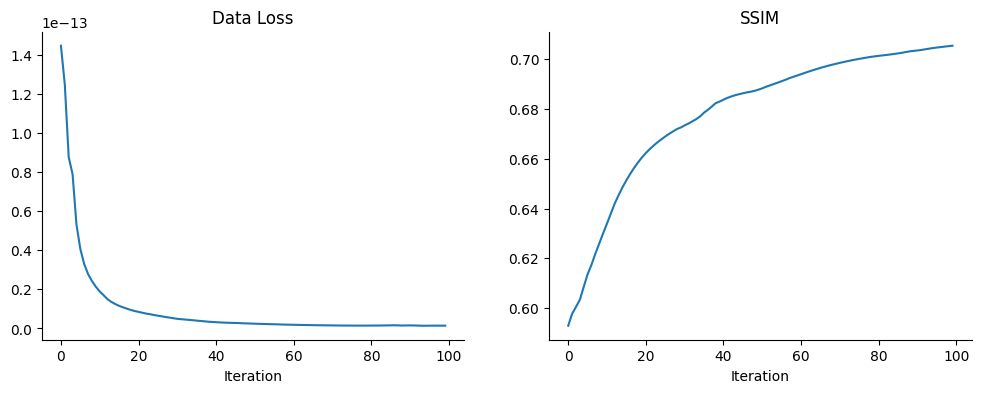

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(fwi_loss)
axs[0].set_title('Data Loss')
axs[0].set_xlabel('Iteration')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].plot(ssim_list)
axs[1].set_title('SSIM')
axs[1].set_xlabel('Iteration')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.savefig(f'{exp_name}/losses.png',  bbox_inches='tight', dpi=300)

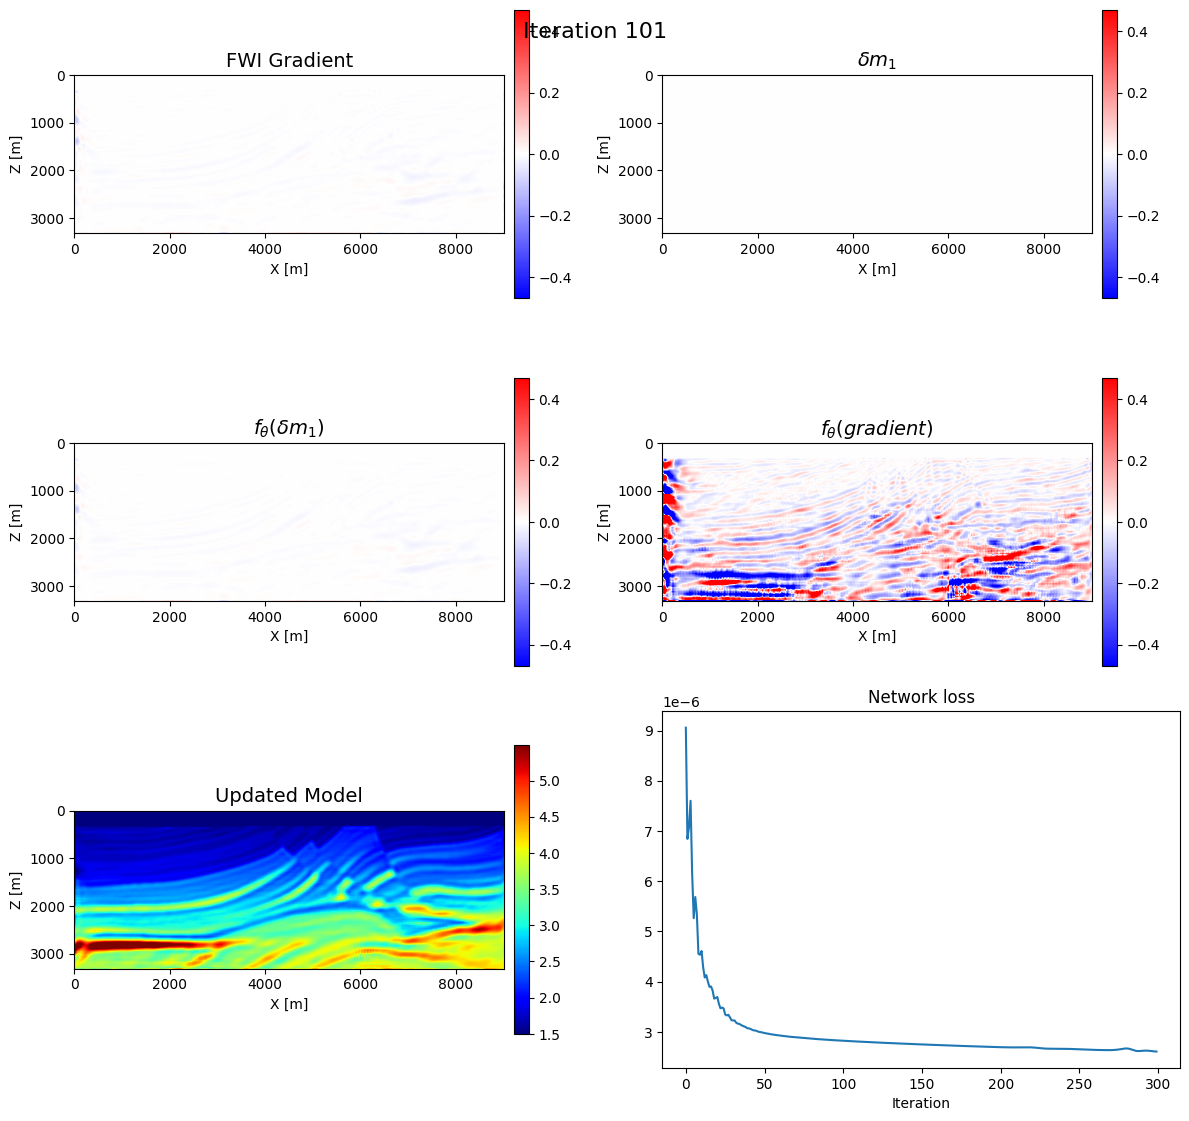

In [15]:
show_one_iter_dm(grad.cpu(), dm1.cpu(), g.cpu(), dm.cpu(), model.detach().cpu(), lossn, iteration=FWI_iter,
                cmap='bwr', vmin=m_vmin, vmax=m_vmax, extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0),)

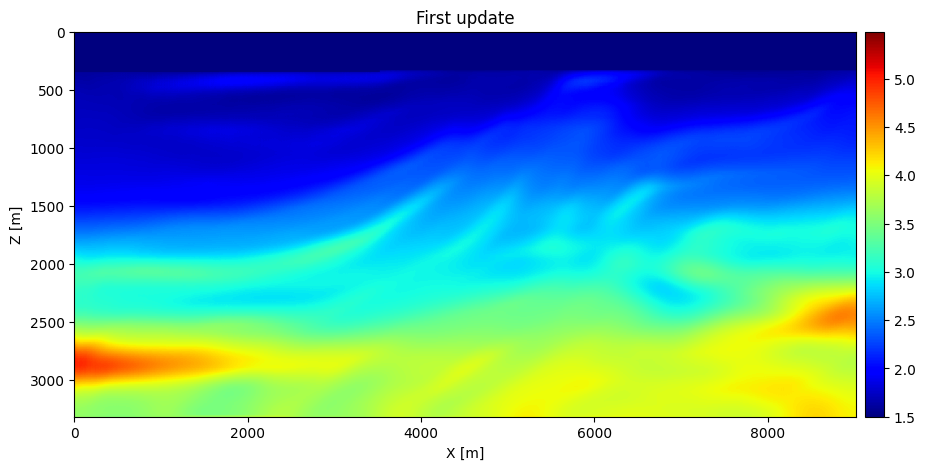

In [16]:
show_model(updates[0], cmap='jet', vmin=m_vmin, vmax=m_vmax, figsize=(12, 5), extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0),
           title='First update')

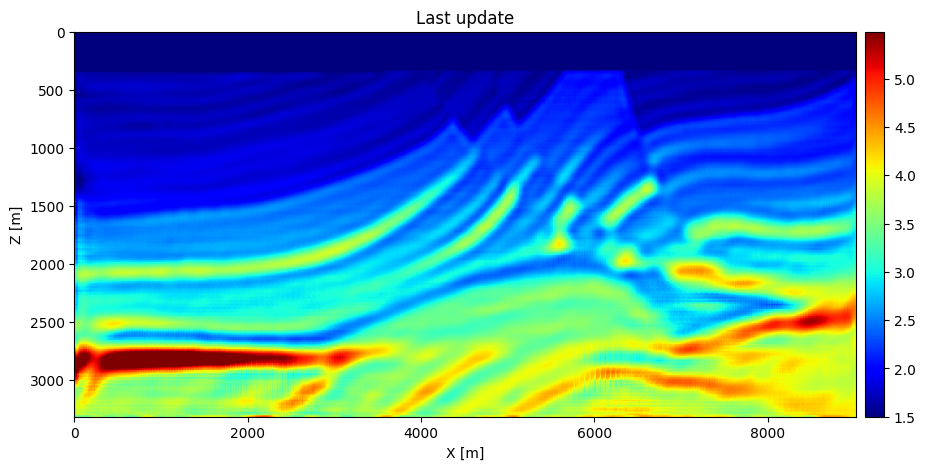

In [17]:
show_model(updates[-1], cmap='jet', vmin=m_vmin, vmax=m_vmax, figsize=(12, 5), extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0),
           title='Last update')